# LCP Project: MAGIC data analysis
---

## Group 11
***Brocco Luca*** - 2165810
<br> ***Cafagno Samuele*** - 2159164
<br> ***Cavallin Jonathan*** - 2159285
<br> ***Di Lucia Sofia*** - 2149752

### Description

The data are Monte Carlo generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

### Dataset

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm]
2. fWidth: continuous # minor axis of ellipse [mm]
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot]
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio]
5. fConc1: continuous # ratio of highest pixel over fSize [ratio]
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm]
7. fM3Long: continuous # 3rd root of third moment along major axis [mm]
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm]
9. fAlpha: continuous # angle of major axis with vector to origin [deg]
10. fDist: continuous # distance from origin to center of ellipse [mm]
11. class: g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332
h = hadron (background): 6688

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events.

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.


### References

[1] Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004).
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope.
Nucl.Instr.Meth. A, 516, pp. 511-528.

[2] P. Savicky, E. Kotrc.
Experimental Study of Leaf Confidences for Random Forest.
Proceedings of COMPSTAT 2004, In: Computational Statistics. (Ed.: Antoch J.) - Heidelberg, Physica Verlag 2004, pp. 1767-1774.

[3] J. Dvorak, P. Savicky.
Softening Splits in Decision Trees Using Simulated Annealing.
Proceedings of ICANNGA 2007, Warsaw, (Ed.: Beliczynski et. al), Part I, LNCS 4431, pp. 721-729.

[4] Aharonian, F. et al.
The Energy Spectrum of TeV Gamma-Rays from the Crab Nebula as measured by the HEGRA system of imaging air Cherenkov telescopes
Astrophys. J. 539 (2000) 317-324

[5] Aleksic, J. et al.
Measurement of the Crab Nebula spectrum over three decades in energy with the MAGIC telescopes
Journal of High Energy Astrophysics, 5–6 (2015) 30-38.

# Part 0: setup
First, we import the libraries

In [40]:
# math libraries
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
import uncertainties as un
from scipy import linalg as la
from matplotlib import patches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as path_effects
import seaborn as sns
import random as rnd
import sympy as sp
from scipy.integrate import romb
from scipy.integrate import simpson

# general OS libraries
from time import time
import gzip
import os
import operator
import warnings
from IPython.core.interactiveshell import InteractiveShell

# ML libraries
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.datasets import make_classification
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')


Then, we import the dataset and we put it into a DataFrame:

In [41]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

file_name="magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']
data
## save data in a DataFrame

--2025-03-19 22:08:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘magic04.data.2’

magic04.data.2          [   <=>              ]   1.41M  3.30MB/s    in 0.4s    

2025-03-19 22:08:03 (3.30 MB/s) - ‘magic04.data.2’ saved [1477391]



,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,category
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
...,...,...,...,...,...,...,...,...,...,...,...
19014,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19015,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19016,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19017,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


We print the number of data of each label and the relative frequence

In [42]:
print('All data points:',len(data['fAlpha']),'points for',len(data.columns[:]),'columns')
print('labels and their relative frequencies:')

ngamma = len(data[data['category'] == 'g'] )
nback = len(data[data['category'] == 'h'] )
print(f'signal: \t{ngamma} \t {round(ngamma/len(data["fAlpha"])*100,2)}%')
print(f'background:\t {nback} \t {round(nback/len(data["fAlpha"])*100,2)}%')



All data points: 19019 points for 11 columns
labels and their relative frequencies:
signal: 	12331 	 64.84%
background:	 6688 	 35.16%


We observe that about 2/3 of the dataset is labelled as signal, while only 1/3 as background. The dataset is indeed built underestimating the amount of background signal acquired.

## Definition of the functions

Here we write some useful functions for the code

### ML functions

In [43]:
# this function divides the dataset in input in parts_to_be_split parts. One of them is returned as test_set
# the other ones are the training_set. Indexes of the chosen data can be accessed (test_indexes, train_indexes)
# (for example in a K-fold)

def split_train_test_set(data,parts_to_be_split):
    indexes = np.arange(0,data.shape[0],1)
    rnd.shuffle(indexes)
    len_test_set = int(len(indexes) / parts_to_be_split)

    test_indexes = indexes[:len_test_set]
    train_indexes = indexes[len_test_set:]

    train_set = data.iloc[train_indexes]
    test_set = data.iloc[test_indexes]

    return train_set, test_set

# this function takes col category and returns as Y (target), the other columns are X (labels)
def split_X_Y(data):
    Y = data['category']
    X = data.drop('category',axis=1)

    return X,Y

# this function takes the point that has the lowest distance from FPR=0 and TPR=1 and computes Q for that point values
def get_best_Q(fpr,tpr):
    distances = np.zeros(len(fpr))

    for i in range(len(fpr)):
        distances[i] = np.sqrt(fpr[i]**2+(1-tpr[i])**2)

    min_dist_idx = np.argmin(distances)

    best_Q = tpr[min_dist_idx] / np.sqrt(fpr[min_dist_idx])
    return best_Q

## Other functions
### Cutting functions

In [44]:
# this function finds cut value starting from possible max
def find_max_cut_value(X_train,Y_train,sel_label,min_hadrons):
    new_X = X_train[X_train.columns[sel_label]]
    new_data = np.vstack((new_X,Y_train))
    new_data_sorted = new_data[:, new_data[0].argsort()]


    # setup vars, cut value is  set to max of the label, so that in worst scenario all points are true hadrons
    true_hadrons = 0
    max_cut_value = new_data_sorted[0,0]

    for i in range(new_data_sorted.shape[1]):
        if new_data_sorted[1,i] == -1:
            true_hadrons += 1
        if true_hadrons == min_hadrons:
            max_cut_value = new_data_sorted[0,i]

    return max_cut_value

# this functions returns the number of true positive and false positive points on test set
def find_tp_fp(X_test,Y_test,sel_label,cut_value):
    new_X = X_test[X_test.columns[sel_label]]
    new_data = np.vstack((new_X,Y_test))
    new_data_sorted = new_data[:, new_data[0].argsort()]
    new_data_sorted_reversed = new_data_sorted[:, ::-1] #reverse!! STARTING FROM MAXX
    fp = 0
    tp = 0

    for i in range(new_data_sorted_reversed.shape[1]):
        if new_data_sorted_reversed[0,i] < cut_value:
            if new_data_sorted_reversed[1,i] == 1:
                tp += 1
            if new_data_sorted_reversed[1,i] == -1:
                fp += 1

    return tp, fp # true positive, false positive

# Part 1: study of the dataset


### Part 1.1 Camera plane reconstruction
The following code recontrsucts the traces detected by the telescope camera. In orange and red are represented the detected gammas, while in blue are represented the detected hadrons.

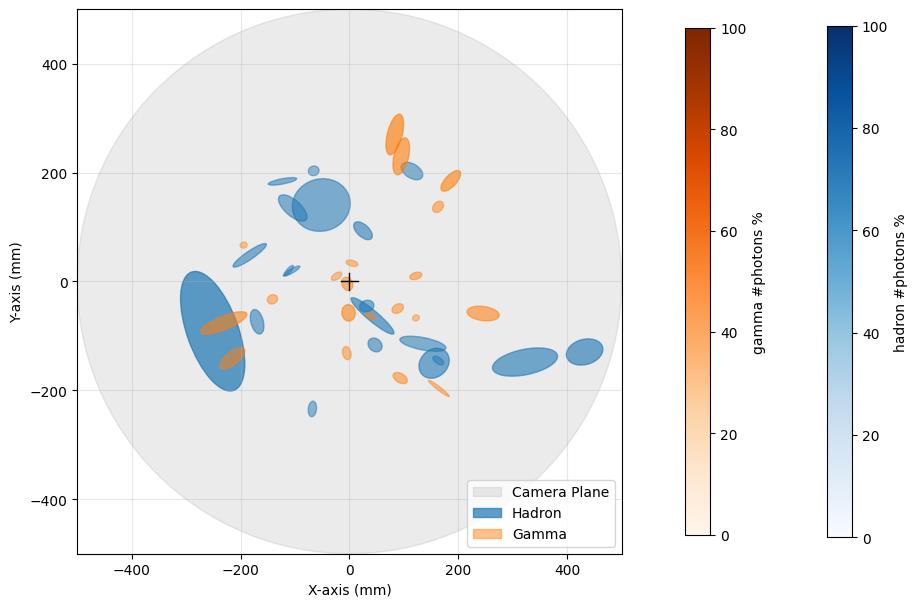

In [45]:
datasig = data[data['category'] == 'g']
databkg = data[data['category'] == 'h']
# visualize data
n_ellipses = 20

# ellipse parameters
random_angle_sig = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
sig_idx = np.random.randint(0,10000, size=n_ellipses)
sig_ellipse_params = [
    {
        'center': (datasig['fDist'][idx] * np.cos(random_angle_sig[i]), datasig['fDist'][idx] * np.sin(random_angle_sig[i])),
        'width': datasig['fWidth'][idx],
        'height': datasig['fLength'][idx],
        'angle': datasig['fAlpha'][idx],
        'alpha': datasig['fSize'][idx]/data['fSize'].max()
        }
    for i, idx in enumerate(sig_idx)
    ]

random_angle_bkg = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
bkg_idx = np.random.randint(13000,19000, size=n_ellipses)
bkg_ellipse_params = [
    {
        'center': (databkg['fDist'][idx] * np.cos(random_angle_bkg[i]), databkg['fDist'][idx] * np.sin(random_angle_bkg[i])),
        'width': databkg['fWidth'][idx],
        'height': databkg['fLength'][idx],
        'angle': databkg['fAlpha'][idx],
        'alpha': databkg['fSize'][idx]/data['fSize'].max()
        }
    for i, idx in enumerate(bkg_idx)
    ]

fig, ax = plt.subplots(figsize=(10,12))

ax.grid(alpha=0.3)

# plot ellipses
radius = 500
camera_circle = patches.Circle((0,0), radius, alpha=0.15, color='#7a7a7a')
ax.add_patch(camera_circle)

bkg_ellipses = []
sig_ellipses = []

for params in bkg_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'],
        width=params['width'],
        height=params['height'],
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi),
        fill=True,
        alpha=params['alpha'],
        color='C0'
        )
    ax.add_patch(ellipse)
    bkg_ellipses.append(ellipse)

for params in sig_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'],
        width=params['width'],
        height=params['height'],
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi),
        alpha=params['alpha'],
        color='C1'
        )
    ax.add_patch(ellipse)
    sig_ellipses.append(ellipse)

ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_aspect('equal')

legend_labels = ['Camera Plane', 'Hadron', 'Gamma']
legend_handles = [camera_circle, bkg_ellipses[0], sig_ellipses[0]]
ax.legend(legend_handles, legend_labels, loc='lower right')

center_cross_size = 15
ax.plot([0, 0], [-center_cross_size, center_cross_size], color='black', linewidth=1)
ax.plot([-center_cross_size, center_cross_size], [0, 0], color='black', linewidth=1)

# color scale indicating alpha for background ellipses
bkg_alphas = [params['alpha'] for params in bkg_ellipse_params]
bkg_norm = Normalize(vmin=0, vmax=100)
bkg_scalar_map = ScalarMappable(norm=bkg_norm, cmap='Blues')
bkg_scalar_map.set_array(bkg_alphas)
bkg_colorbar = plt.colorbar(bkg_scalar_map, ax=ax, fraction=0.033, pad = 0.15)
bkg_colorbar.set_label('hadron #photons %')

# color scale indicating alpha for signal ellipses
sig_alphas = [params['alpha'] for params in sig_ellipse_params]
sig_norm = Normalize(vmin=0, vmax=100)
sig_scalar_map = ScalarMappable(norm=sig_norm, cmap='Oranges')
sig_scalar_map.set_array(sig_alphas)
sig_colorbar = plt.colorbar(sig_scalar_map, ax=ax, fraction=0.04, pad = 0.1)
sig_colorbar.set_label('gamma #photons %')

ax.set_xlabel('X-axis (mm)')
ax.set_ylabel('Y-axis (mm)')

plt.show();

This recontstruction resembles the acquisition of some signals. It is observed that the orange ellipsis, representing data labeled as "gamma", are mostly radially oriented, while the orientation of the "hadrons" ellipses seems random. We can conclude that the photon shower axis is parallel to the telescope's optical axis. The colorbars represent the percentage of photons inside each ellipses.

### Part 1.2 Plot of the features
The following code plots histograms for each feature, in red there are gammas (signal), in blue hadrons (background). The code saves the histograms in a directory named 'part_1_plots'

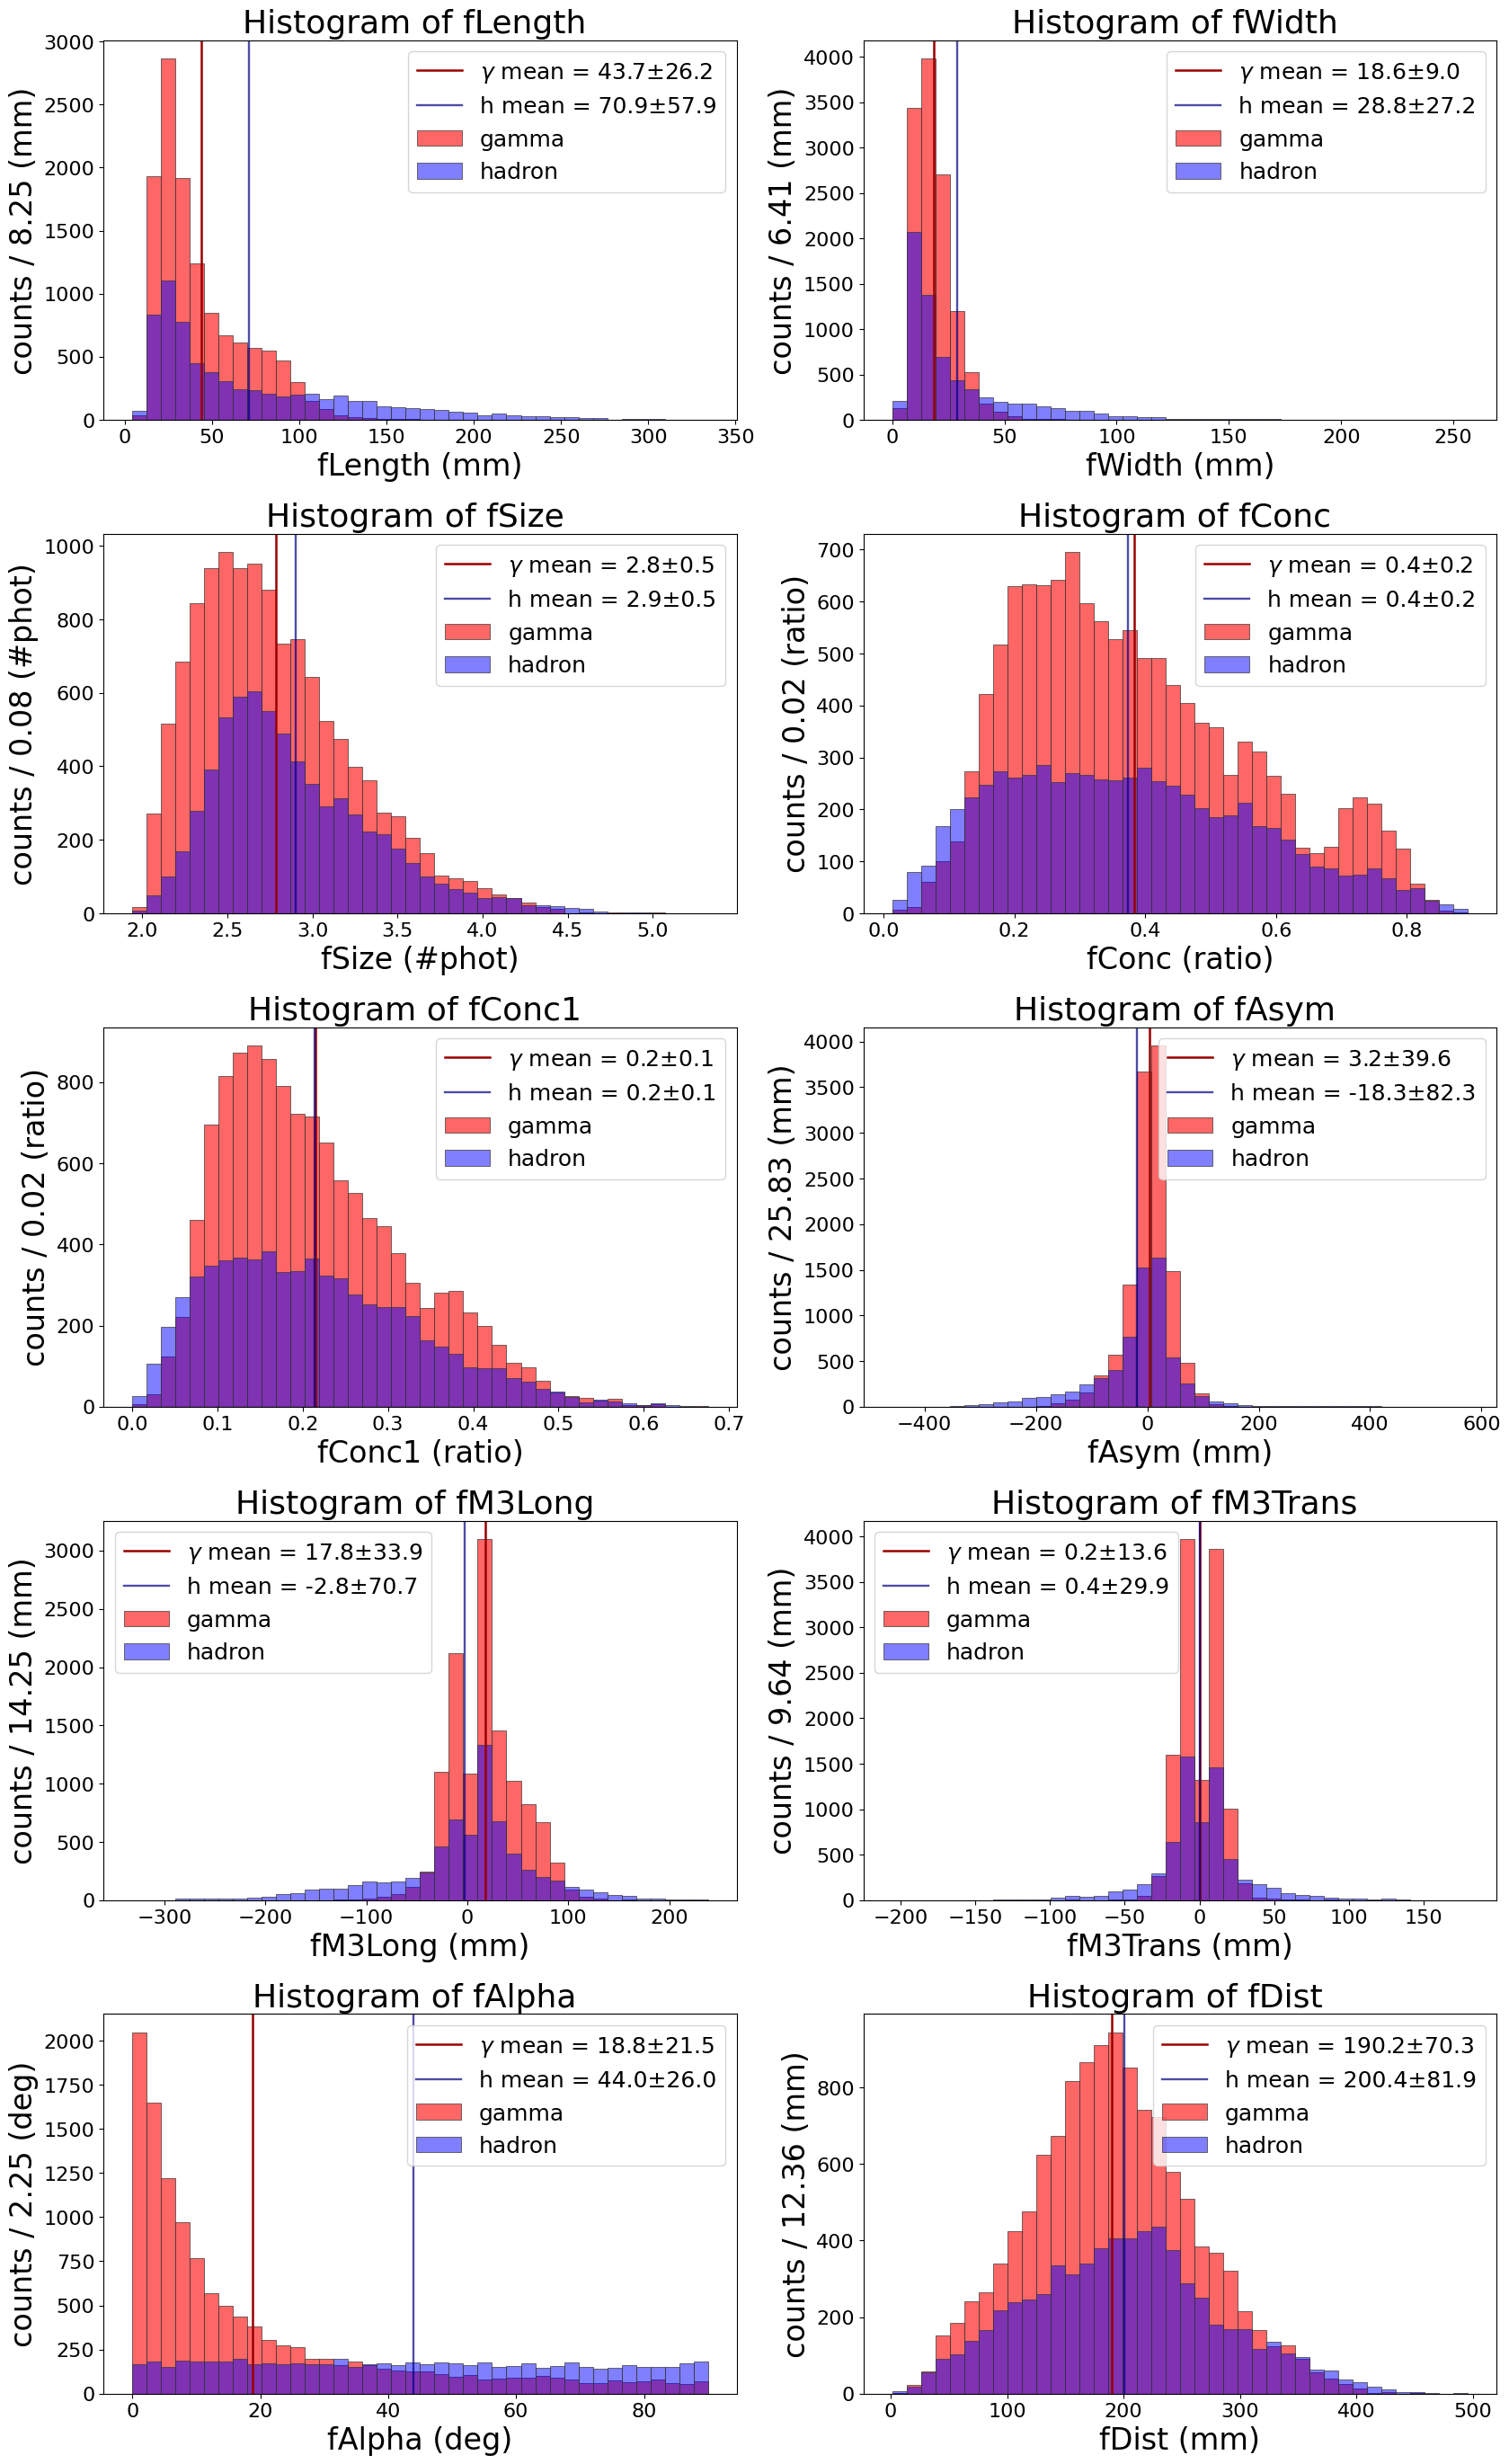

In [46]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 34))
fig.subplots_adjust(hspace=0.3)

udm = ['fLength ', 'fWidth ', 'fSize ', 'fConc ', 'fConc1 ',
       'fAsym ', 'fM3Long ', 'fM3Trans ', 'fAlpha ', 'fDist ']

units = ['(mm)','(mm)','(#phot)','(ratio)','(ratio)','(mm)','(mm)','(mm)','(deg)','(mm)']
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1',
            'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
bins = 40

avgs_g = []
avgs_h = []
stds_g = []
stds_h = []
lambdas = []

for i in range(5):
    for j in range(2):

        idx = 2 * i + j  # Update index to match new layout
        if (udm[idx] == 'fWidth (mm)'):
            bins = 50

        min_val = min(datasig[features[idx]].min(), databkg[features[idx]].min())
        max_val = max(datasig[features[idx]].max(), databkg[features[idx]].max())
        common_bins = np.linspace(min_val, max_val, bins + 1)

        sns.histplot(datasig[features[idx]], bins = common_bins, kde=False, color='red', alpha=0.6, label='gamma', ax=ax[i, j], edgecolor='#383734', linewidth=0.5)
        sns.histplot(databkg[features[idx]], bins = common_bins, kde=False, color='blue', alpha=0.5, label='hadron', ax=ax[i, j], edgecolor='#383734', linewidth=0.5)
        mu_g = np.mean(datasig[features[idx]])
        mu_h = np.mean(databkg[features[idx]])
        std_g = np.std(datasig[features[idx]])
        std_h = np.std(databkg[features[idx]])
        avgs_g.append(mu_g)
        avgs_h.append(mu_h)
        stds_g.append(std_g)
        stds_h.append(std_h)
        lambdas.append(abs(mu_g-mu_h)/(std_g**2 + std_h**2)**(1/2))

        ax[i, j].axvline(mu_g,c='#990000', label= f'$\gamma$ mean = {round(mu_g,1)}±{round(std_g,1)}', lw=1.8)
        ax[i, j].axvline(mu_h,c='navy',label= f'h mean = {round(mu_h,1)}±{round(std_h,1)}', lw=1.7,alpha=0.7)
        ax[i, j].set_xlabel(f'{udm[idx]}{units[idx]}', fontsize=24)
        ax[i, j].set_ylabel(f'counts / {round(common_bins[1]-common_bins[0],2)} {units[idx]}', fontsize=24)
        ax[i, j].tick_params(axis='both', which='major', labelsize=16)
        ax[i, j].legend(loc='best', fontsize=18)
        ax[i, j].set_title(f'Histogram of {udm[idx]}', fontsize=26)

plt.show();

In [47]:
print(f'feature \t gamma \t \thadrons \tcompatibility (lambda)')
for i in range(len(avgs_g)):
    print(f'{udm[i]}{units[i]}\t',f'{round(avgs_g[i],1)} \u00B1 {round(stds_g[i],1)}', f'\t{round(avgs_h[i],1)} \u00B1 {round(stds_h[i],1)}', f'\t\033[32m{round(lambdas[i],2)}\033[0m')

feature 	 gamma 	 	hadrons 	compatibility (lambda)
fLength (mm)	 43.7 ± 26.2 	70.9 ± 57.9 	0.43
fWidth (mm)	 18.6 ± 9.0 	28.8 ± 27.2 	0.36
fSize (#phot)	 2.8 ± 0.5 	2.9 ± 0.5 	0.17
fConc (ratio)	 0.4 ± 0.2 	0.4 ± 0.2 	0.04
fConc1 (ratio)	 0.2 ± 0.1 	0.2 ± 0.1 	0.01
fAsym (mm)	 3.2 ± 39.6 	-18.3 ± 82.3 	0.24
fM3Long (mm)	 17.8 ± 33.9 	-2.8 ± 70.7 	0.26
fM3Trans (mm)	 0.2 ± 13.6 	0.4 ± 29.9 	0.01
fAlpha (deg)	 18.8 ± 21.5 	44.0 ± 26.0 	0.75
fDist (mm)	 190.2 ± 70.3 	200.4 ± 81.9 	0.09


We observe that the mean values of all features for hadrons and gammas are compatible. Also they distribute in similar shapes, except for `fAlpha`. Therefore is not possible to distinguish signal from background from the distributions.

# Part 2: studying the correlations
In this section we rescale all features to have average = 0 and dev_std = 1 (Alpha is rescaled in this part, but will be restored for the later sections) and then compare them with each other and represent the results in a 2D correlation matrix (n_features x n_features).


In [48]:
X = data[['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist']]
Y = data['category']
print(X['fAlpha'])


0         6.3609
1        76.9600
2        10.4490
3         4.6480
4         3.6130
          ...   
19014     2.4229
19015    86.7975
19016    30.2987
19017    84.6874
19018    52.7310
Name: fAlpha, Length: 19019, dtype: float64


In [49]:
X_rescaled = X.copy()
original_alpha = X['fAlpha'].copy()

for i in range(X.shape[1]):
    h = X[str(X.columns[i])]
    avg = np.average(h)
    std = np.std(h)
    h = h - avg
    h = h / std
    X_rescaled[str(X_rescaled.columns[i])] = h

print('avg length:',round(np.average(X_rescaled['fLength']),15))
print('std length:',round(np.std(X_rescaled['fLength']),15))

avg length: 0.0
std length: 0.999999999999997


The following cell computes searately the correlation matrix for gammas and hadrons

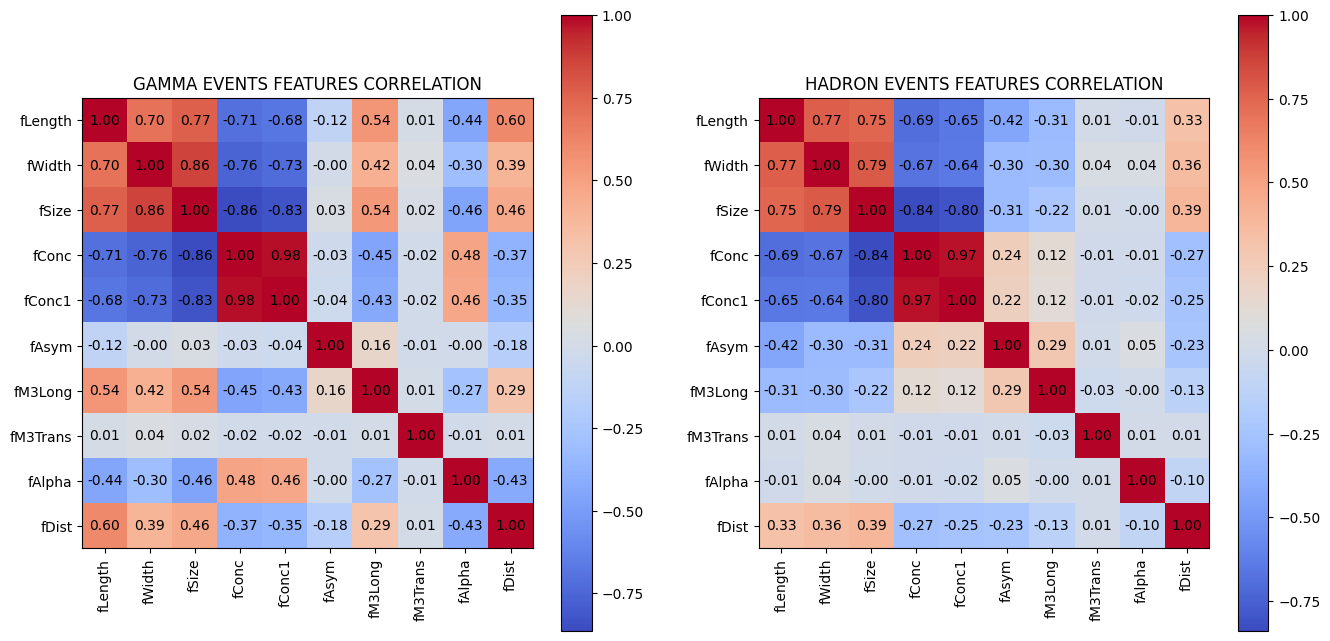

In [50]:
Xg_rescaled = X_rescaled[Y == 'g']
Xh_rescaled = X_rescaled[Y == 'h']
features = features[:10]


cov = np.zeros((Xg_rescaled.shape[1],Xg_rescaled.shape[1]))
for i in range(Xg_rescaled.shape[1]):
    h = Xg_rescaled[str(Xg_rescaled.columns[i])]
    for j in range(Xg_rescaled.shape[1]):
        v = Xg_rescaled[str(Xg_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])

std_devs = np.std(Xg_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs) # the data for gamma events are not normalized with respsect to themselv



ticks = np.arange(0,10,1)
x_ticks = np.arange(cov.shape[1]) + 0.5
y_ticks = np.arange(cov.shape[0]) + 0.5

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
cax = ax[0].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[0].set_xticks(ticks, minor=False)
ax[0].set_yticks(ticks, minor=False)
ax[0].set_xticklabels(features,rotation=90)
ax[0].set_yticklabels(features)
ax[0].grid(which='minor', color='black', linewidth=2)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[0].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

ax[0].set_title('GAMMA EVENTS FEATURES CORRELATION')

cov = np.zeros((Xh_rescaled.shape[1],Xh_rescaled.shape[1]))
for i in range(Xh_rescaled.shape[1]):
    h = Xh_rescaled[str(Xh_rescaled.columns[i])]
    for j in range(Xh_rescaled.shape[1]):
        v = Xh_rescaled[str(Xh_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])

std_devs = np.std(Xh_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs)

cax = ax[1].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[1].set_xticks(ticks, minor=False)
ax[1].set_yticks(ticks, minor=False)
ax[1].set_xticklabels(features, rotation=90)
ax[1].set_yticklabels(features)
ax[1].grid(which='minor', color='black', linewidth=1)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[1].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

ax[1].set_title('HADRON EVENTS FEATURES CORRELATION')

plt.show();

We observe that the most correlated features are the first 5. The correlation between the first 3 is positive, while correlation between `fConc` and `fConc1` is negative, and very close to 1. This is in agreement for both signal and background events. Differences can be seen while observing other parameters:
- `fAlpha`: this parameter is slightly correlated to the others for gamma events, but sees almost no correlation for background ones
- `fAsym`: this parameter sees the opposite than `fAlpha`
- `fM3Long`: the correlation of this parameter is present for both signal and background events, but has its sign swapped

## Part 2.1: Correlation between features and label
In this part we check the correlation between features and label Y. This is done to find the most informative parameters for the classification.

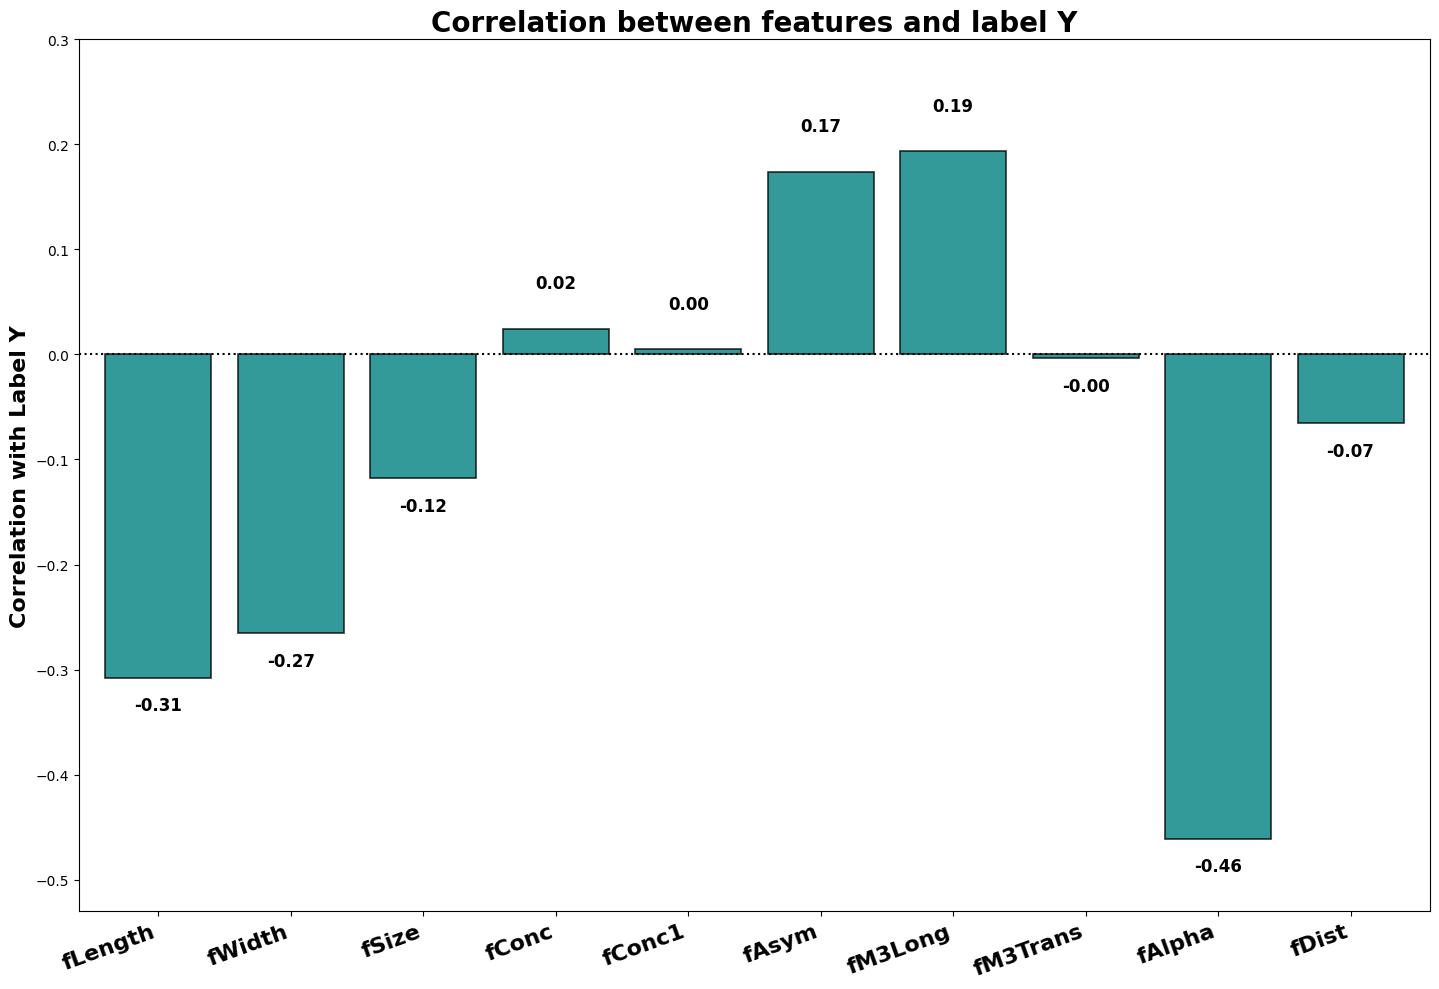

In [51]:
# Calculate the correlation between each feature and the label Y

Y_array = np.where(Y == 'g', 1, -1)
Y_array = np.array(Y_array)
feature_names = data.columns[:10]

correlations = np.zeros(X_rescaled.shape[1])
for i in range(X_rescaled.shape[1]):
    feature = X_rescaled.iloc[:, i]
    correlations[i] = np.corrcoef(feature, Y_array)[0, 1]

# create a bar plot to display the correlations
fig, ax = plt.subplots(figsize=(14.5, 10))

bars = ax.bar(feature_names, correlations, color='teal', edgecolor='black', linewidth=1.2,alpha=0.8)

# add correlation values on top of each bar
for i, corr in enumerate(correlations):
    ax.text(i, corr + 0.035 if corr>=0 else corr-0.035, f'{corr:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_ylabel('Correlation with Label Y', fontsize=16, fontweight='bold')
ax.set_ylim(-0.53,0.3)
ax.set_title('Correlation between features and label Y', fontsize=20, fontweight='bold')
ax.set_xticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, fontsize=16, fontweight='bold', rotation=20, ha='right')

x_line = np.linspace(-0.6,len(feature_names),100)
y_line = np.linspace(0,0,100)
ax.plot(x_line, y_line, linestyle='dotted', color='black')
ax.set_xlim(-0.6,9.6)

plt.tight_layout()
plt.show()

The features most strongly correlated with the label Y, and thus most informative for distinguishing between gamma and hadron events, are `fAlpha`
, `flength` and `fWidth` This is coherent with our observations from the feature histograms, where these features exhibit more distinct distributions between the two classes.

# Part 3: comparison of high energy and low energy events

In this section we analyze the distributions of the rescaled `fWidth` and `fLength` parameters. First of all we have computed the mean and standard deviation for both samples and we rescaled them. Then the distribution of both `fWidth` and `fLength` was plotted dividing the gamma from the hadron events.

We then used the `fSize` parameter to apply a cut to both the signals (gamma) and background (hadron) events and considered only the tails of their distribution. Since `fSize` is proportional to the number of photons, for both the width and lenght distribution we defined as "High energy events" the data points higher than 𝜇+𝜎
(right-side tail) and as "Low energy events" the data points lower than 𝜇−𝜎. Considering 𝜇 and 𝜎 rispectively as the mean and standard deviation of the rescaled width and lenght distributions.


In [52]:
## find mean and std

mu_l=data['fLength'].mean()
std_l=data['fLength'].std()
mu_w=data['fWidth'].mean()
std_w=data['fWidth'].std()
print('Length attribute:   mean = ', round(mu_l,3), '    std = ', round(std_l,3))
print('Width attribute:    mean = ', round(mu_w,3), '   std = ', round(std_w,3))
data['scaled_fLength']= (data['fLength']-mu_l)/std_l   # add a scaled comlumn to the DataFrame
data['scaled_fWidth']= (data['fWidth']-mu_w)/std_w

Length attribute:   mean =  53.251     std =  42.366
Width attribute:    mean =  22.181    std =  18.346


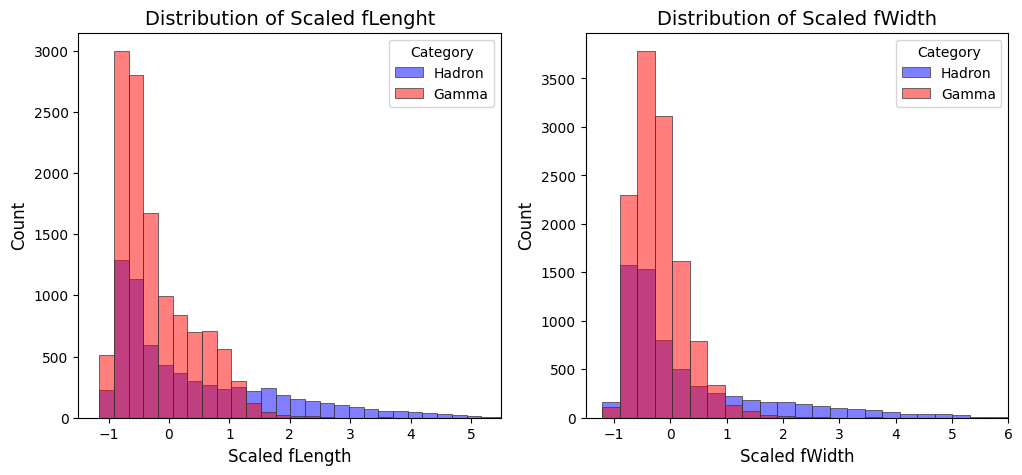

In [53]:
## plots of the scaled distribution before cutting

bins = 32
common_bins = np.linspace(min(data['scaled_fLength']), max(data['scaled_fLength']), bins + 1)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(data,x=data['scaled_fLength'],hue='category',bins = common_bins, kde=False, ax=ax[0], palette=['red','blue'], edgecolor='#383734', linewidth=0.5)
ax[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax[0].set_xlabel("Scaled fLength", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].set_xlim(-1.5, 5.5)
legend = ax[0].get_legend()

ax[0].legend(['Hadron', 'Gamma'], title='Category')

bins = 45
common_bins = np.linspace(min(data['scaled_fWidth']), max(data['scaled_fWidth']), bins + 1)
sns.histplot(data,x=data['scaled_fWidth'],hue='category',bins = common_bins, kde=False, ax=ax[1], palette=['red','blue'], edgecolor='#383734', linewidth=0.5)
ax[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax[1].set_xlabel("Scaled fWidth", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].set_xticks(range(-1,9))
ax[1].set_xlim(-1.5, 6)
legend = ax[1].get_legend()
ax[1].legend(['Hadron', 'Gamma'], title='Category');


In [54]:
median_fSize = data['fSize'].median()
min_fSize = data['fSize'].min()
max_fSize = data['fSize'].max()
mean_fSize = data['fSize'].mean()
std_fSize = data['fSize'].std()
print("Statistichal informations of fSize: \nmedian=",median_fSize, '\nmin=', min_fSize, '\nmax=', max_fSize, '\nmean=', round(mean_fSize,3), '\nstd=', round(std_fSize,3))


Statistichal informations of fSize: 
median= 2.7396 
min= 1.9413 
max= 5.3233 
mean= 2.825 
std= 0.473


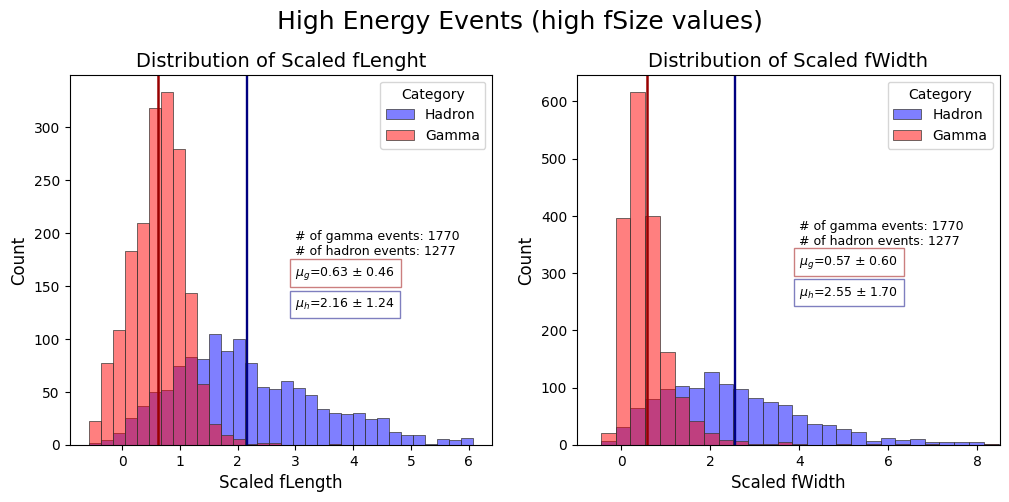

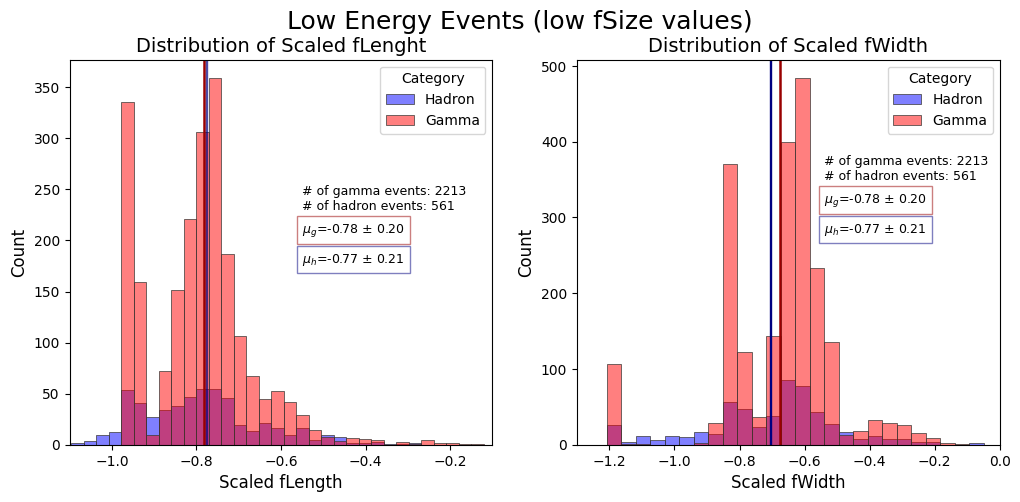

In [55]:
#### plots at high energy

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('High Energy Events (high fSize values)', fontsize=18)

fig.subplots_adjust(top=0.85)

##useful variables
ng_high=len(data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize])
nh_high=len(data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize])
l_mu_g_high=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].mean()
l_mu_h_high=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].mean()
l_std_g_high=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].std()
l_std_h_high=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].std()
w_mu_g_high=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].mean()
w_mu_h_high=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].mean()
w_std_g_high=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].std()
w_std_h_high=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].std()

##plot length - high energy
sns.histplot(data,x=data['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize],hue='category',hue_order=['g', 'h'], kde=False, color='blue', ax=ax[0], palette=['red','blue'], edgecolor='#383734', linewidth=0.5,bins=32)

ax[0].legend(['Hadron', 'Gamma'], title='Category')
ax[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax[0].set_xlabel("Scaled fLength", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].axvline(l_mu_g_high,c='#990000', label= r'$\mu_{g}$', lw=1.8)
ax[0].axvline(l_mu_h_high,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[0].get_legend()

ax[0].text(x=3,y=180,s=f"# of gamma events: {ng_high} \n# of hadron events: {nh_high}", fontsize=9, color='black')
ax[0].text(x=3,y=160,s=fr"$\mu_{{g}}$={l_mu_g_high:.2f} $\pm$ {l_std_g_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax[0].text(x=3,y=130,s=fr"$\mu_{{h}}$={l_mu_h_high:.2f} $\pm$ {l_std_h_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

#plot width - high energy
sns.histplot(data,x=data['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize],hue='category', kde=False, color='blue', ax=ax[1], palette=['red','blue'], edgecolor='#383734', linewidth=0.5,bins=40)
ax[1].legend(['Hadron', 'Gamma'], title='Category')
ax[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax[1].set_xlabel("Scaled fWidth", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].set_xlim(-1,8.5)
ax[1].axvline(w_mu_g_high,c='#990000', lw = 1.8) #label= r'$\mu_{g}$', lw=1.8)
ax[1].axvline(w_mu_h_high,c='navy', lw = 1.7) #label=r'$\mu_{h}$', lw=1.7)
legend = ax[1].get_legend()

ax[1].text(x=4,y=350,s=f"# of gamma events: {ng_high} \n# of hadron events: {nh_high}", fontsize=9, color='black')
ax[1].text(x=4,y=315,s=fr"$\mu_{{g}}$={w_mu_g_high:.2f} $\pm$ {w_std_g_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax[1].text(x=4,y=260,s=fr"$\mu_{{h}}$={w_mu_h_high:.2f} $\pm$ {w_std_h_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

#### plots at low energy

fig1, ax1 = plt.subplots(1, 2, figsize=(12,5))
fig1.suptitle('Low Energy Events (low fSize values)', fontsize=18)
fig.subplots_adjust(top=0.85)
###useful variables
ng_low=len(data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize])
nh_low=len(data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize])
l_mu_g_low=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].mean()
l_mu_h_low=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].mean()
l_std_g_low=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].std()
l_std_h_low=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].std()
w_mu_g_low=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].mean()
w_mu_h_low=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].mean()
w_std_g_low=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].std()
w_std_h_low=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].std()

## plot length - low energy
sns.histplot(data,x=data['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize],hue='category', kde=False, color='blue', ax=ax1[0], palette=['red','blue'],edgecolor='#383734', linewidth=0.5, bins=180)
ax1[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax1[0].legend(['Hadron', 'Gamma'], title='Category')
ax1[0].set_xlabel("Scaled fLength", fontsize=12)
ax1[0].set_ylabel("Count", fontsize=12)
ax1[0].axvline(l_mu_g_low,c='#990000', label= r'$\mu_{g}$', lw=1.8)
ax1[0].axvline(l_mu_h_low,c='navy',label=r'$\mu_{h}$', lw=1.7,alpha=0.7)
legend = ax[0].get_legend()

ax1[0].set_xlim(-1.1,-0.1)
ax1[0].text(x=-0.55,y=230,s=f"# of gamma events: {ng_low} \n# of hadron events: {nh_low} ", fontsize=9, color='black')
ax1[0].text(x=-0.55,y=208,s=fr"$\mu_{{g}}$={l_mu_g_low:.2f} $\pm$ {l_std_g_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax1[0].text(x=-0.55,y=178,s=fr"$\mu_{{h}}$={l_mu_h_low:.2f} $\pm$ {l_std_h_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

## plot width - low energy
sns.histplot(data,x=data['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize],hue='category', kde=False, color='blue', ax=ax1[1], palette=['red','blue'], edgecolor='#383734', linewidth=0.5,bins=30)
ax1[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax1[1].legend(['Hadron', 'Gamma'], title='Category')
ax1[1].set_xlabel("Scaled fWidth", fontsize=12)
ax1[1].set_ylabel("Count", fontsize=12)
ax1[1].set_xlim(-1.3,0.0)
ax1[1].axvline(w_mu_g_low,c='#990000', label= r'$\mu_{g}$', lw=1.8)
ax1[1].axvline(w_mu_h_low,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[1].get_legend()
ax1[1].text(x=-0.54,y=350,s=f"# of gamma events: {ng_low} \n# of hadron events: {nh_low}", fontsize=9, color='black')
ax1[1].text(x=-0.54,y=320,s=fr"$\mu_{{g}}$={l_mu_g_low:.2f} $\pm$ {l_std_g_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='#990000'))
ax1[1].text(x=-0.54,y=280,s=fr"$\mu_{{h}}$={l_mu_h_low:.2f} $\pm$ {l_std_h_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))


plt.show();

From this comparison we can see that in the high energy tail the signal is more clustered and separated from the background, despite having a smaller number of gamma events in this energy region. Meanwhile in the low energy tail signal and background events are more evenly distributed.

Therefore,considering only the high energy region could give us an edge while classifying the events into signal and background.

# Part 4: PCA
In this part we will perform Principal Component Analysis (PCA). PCA is a statistical tecnique used for reducing the dimensionality of the problem. PCA is done studying in which directions of the feature space the dataset shows significant patterns. This is done computing the covariance matrix and finding its eigenvalues and eigenvectors. The eigenvectors are then used to redefine the feature space and aling data along them. Eigenvectors whose eigenvalues are higher correspond to directions of highest variance in the dataset. This way we can reduce the dimensionality of the problem and focus on the most significant directions. PCA is done separately for signal and background events, to find significative differences in spread for different labels.

In [56]:
file_name="magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))

df= pd.DataFrame(data.values, columns=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class'])
df_1=df[df['class']=='g']
df_0=df[df['class']=='h']
df_1 = df_1.drop(columns=['class']) # no need for label to perform PCA
df_0 = df_0.drop(columns=['class'])

print("Shape of signal data frame:",np.shape(df_1))
print("Shape of bkg data frame:",np.shape(df_0))


Shape of signal data frame: (12331, 10)
Shape of bkg data frame: (6688, 10)


In [57]:
# We re-scale the data-set to mean zero and unitary std before executing the PCA
for column in df_1.columns:
    mean =df_1[column].mean()
    std= df_1[column].std()
    df_1[column]= (df_1[column]-mean)/std
for column in df_0.columns:
    mean =df_0[column].mean()
    std= df_0[column].std()
    df_0[column]= (df_0[column]-mean)/std

In [58]:
df_1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.46046,-0.760816,-0.573381,0.823995,1.527718,0.581262,0.177195,-0.748903,-0.578221,0.213696
1,4.523403,13.006763,2.757867,-1.94532,-1.848775,2.86389,-2.435386,-3.350675,2.708118,0.946671
2,-0.757944,-0.999015,-0.962066,1.298189,1.668012,0.604942,-0.715068,-0.541838,-0.387922,-1.045563
3,1.202731,1.365333,0.814225,-0.375535,-0.299882,-0.221084,0.316503,1.597412,-0.657955,2.36454
4,0.304432,0.283231,0.26877,-0.795793,-0.763137,1.202046,0.747688,0.710088,-0.706133,0.680804
...,...,...,...,...,...,...,...,...,...,...
12326,-1.176177,-0.791727,-0.870077,1.979703,1.557848,-0.462468,-0.368425,0.843377,0.103778,0.196285
12327,-0.641711,0.221696,0.197295,-0.223838,0.001423,-0.168803,-1.113903,-0.682203,-0.688826,0.217067
12328,-0.823883,-0.852587,-1.057078,0.867819,0.723612,0.303856,0.012389,0.531735,0.106385,-0.952475
12329,0.480086,0.012071,0.314549,-0.741856,-0.713234,2.3551,-1.741272,0.825343,-0.599163,0.099156


In [59]:
df_0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
12331,0.392734,0.336335,0.509333,-1.078145,-0.955834,0.869326,1.300189,0.38302,-1.149281,0.384367
12332,0.535902,-0.249909,0.864505,-1.400203,-1.198949,-0.434994,0.649403,-0.515505,1.711764,0.910031
12333,0.506171,-0.254443,0.435676,-0.325283,-0.587349,-0.363269,0.855943,-0.333989,-0.892876,1.783286
12334,0.3574,-0.366573,-0.397221,0.336609,1.084807,-0.417957,-1.34382,-0.583383,0.765787,-0.850547
12335,-0.568118,-0.592947,-0.053908,0.178717,-0.179052,-0.403375,0.158383,0.254152,-0.748348,-0.446646
...,...,...,...,...,...,...,...,...,...,...
19014,-0.855161,-0.657545,-0.591972,1.105678,1.520212,0.407652,0.203334,0.084175,-1.59954,-1.143376
19015,-0.724699,-0.81255,-1.317922,0.841131,0.546058,0.672784,0.226829,-0.111018,1.647644,0.57434
19016,0.077684,0.688905,1.139571,-1.215647,-1.347189,0.108521,0.621122,-0.328377,-0.526731,0.68501
19017,0.855352,1.769025,2.274791,-1.462941,-1.233679,0.292734,-1.282777,-2.145759,1.566436,2.539158


In [60]:
cov_1 = df_1.cov()
cov_0 = df_0.cov()
cov_1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.695644,0.766118,-0.710209,-0.679994,-0.120212,0.542507,0.012337,-0.443232,0.602479
fWidth,0.695644,1.000000,0.855155,-0.761340,-0.731434,-0.002589,0.422045,0.044016,-0.296886,0.389206
fSize,0.766118,0.855155,1.000000,-0.863440,-0.825395,0.029039,0.540963,0.022622,-0.458023,0.459641
fConc,-0.710209,-0.761340,-0.863440,1.000000,0.979332,-0.033398,-0.452184,-0.017356,0.482322,-0.368592
fConc1,-0.679994,-0.731434,-0.825395,0.979332,1.000000,-0.037624,-0.433913,-0.016053,0.463536,-0.347123
fAsym,-0.120212,-0.002589,0.029039,-0.033398,-0.037624,1.000000,0.162435,-0.005598,-0.004571,-0.178190
fM3Long,0.542507,0.422045,0.540963,-0.452184,-0.433913,0.162435,1.000000,0.008234,-0.271465,0.294765
fM3Trans,0.012337,0.044016,0.022622,-0.017356,-0.016053,-0.005598,0.008234,1.000000,-0.007311,0.009752
fAlpha,-0.443232,-0.296886,-0.458023,0.482322,0.463536,-0.004571,-0.271465,-0.007311,1.000000,-0.425032
fDist,0.602479,0.389206,0.459641,-0.368592,-0.347123,-0.178190,0.294765,0.009752,-0.425032,1.000000


In [61]:
cov_0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.773884,0.747319,-0.688524,-0.651879,-0.423194,-0.307349,0.013007,-0.009282,0.325267
fWidth,0.773884,1.000000,0.790355,-0.672618,-0.638750,-0.304118,-0.296956,0.039519,0.041617,0.354997
fSize,0.747319,0.790355,1.000000,-0.839128,-0.796837,-0.305340,-0.223553,0.010992,-0.004228,0.394842
fConc,-0.688524,-0.672618,-0.839128,1.000000,0.972725,0.238806,0.124154,-0.007704,-0.010714,-0.267684
fConc1,-0.651879,-0.638750,-0.796837,0.972725,1.000000,0.220317,0.115716,-0.008235,-0.015137,-0.245179
fAsym,-0.423194,-0.304118,-0.305340,0.238806,0.220317,1.000000,0.285738,0.006849,0.053334,-0.229049
fM3Long,-0.307349,-0.296956,-0.223553,0.124154,0.115716,0.285738,1.000000,-0.026806,-0.001489,-0.131121
fM3Trans,0.013007,0.039519,0.010992,-0.007704,-0.008235,0.006849,-0.026806,1.000000,0.010832,0.013150
fAlpha,-0.009282,0.041617,-0.004228,-0.010714,-0.015137,0.053334,-0.001489,0.010832,1.000000,-0.097112
fDist,0.325267,0.354997,0.394842,-0.267684,-0.245179,-0.229049,-0.131121,0.013150,-0.097112,1.000000


In [62]:
l_1,V_1= la.eig(cov_1)
l_1=l_1.real
V_1=V_1.real
print("Eigenvalues Gamma events:", l_1,'\n')
print("Eigenvectors Gamma events:", V_1,'\n')

Eigenvalues Gamma events: [5.04135896 1.18671249 1.00189813 0.86259252 0.73828989 0.52867675
 0.01763177 0.10500615 0.29317529 0.22465805] 

Eigenvectors Gamma events: [[ 3.86563154e-01  1.64161550e-01 -1.87852855e-02 -5.17321758e-02
   2.27306595e-01 -6.21165157e-02  1.64670468e-02  2.62838530e-02
   3.75283692e-02  8.73323351e-01]
 [ 3.76614052e-01 -6.58692554e-02  5.96665086e-02  3.13862948e-01
   9.53882263e-02 -2.55432045e-01 -4.24256844e-03  4.90484637e-01
   6.23609927e-01 -2.18920288e-01]
 [ 4.17121017e-01 -7.65050692e-02  1.22260020e-02  1.38753617e-01
   1.93685374e-02 -6.00347575e-02  1.05957925e-01 -8.36960174e-01
   2.44851708e-01 -1.58410555e-01]
 [-4.09538760e-01  1.17040480e-01 -9.64678415e-03 -2.30228965e-01
   2.25834045e-01 -6.25170832e-02  7.50095221e-01 -4.79749462e-02
   3.77875580e-01  5.32663335e-02]
 [-3.98738464e-01  1.26974491e-01 -9.56015222e-03 -2.43724055e-01
   2.46152389e-01 -7.37984117e-02 -6.52335699e-01 -1.94150192e-01
   4.81400557e-01  6.61244443e-0

In [63]:
l_0,V_0= la.eig(cov_0)
l_0=l_0.real
V_0=V_0.real
print("Eigenvalues background events:", l_0,'\n')
print("Eigenvectors background events:", V_0,'\n')

Eigenvalues background events: [4.42388448 0.02391582 0.14984033 0.2221564  0.43740477 1.20808117
 0.69931975 0.80384168 1.03760086 0.99395472] 

Eigenvectors background events: [[-4.13567164e-01 -2.63725151e-02 -1.06784542e-01  7.64522513e-01
  -4.62230622e-01 -8.23597651e-02 -5.41729191e-02  7.12962716e-02
   4.76672675e-02 -4.04817037e-02]
 [-4.10369824e-01  1.18010294e-02  4.74225410e-01 -4.98487549e-01
  -5.76267380e-01 -9.62312079e-03  1.32890905e-01 -2.68784361e-02
   8.66124162e-02 -4.11274819e-03]
 [-4.39407630e-01 -1.02147327e-01 -8.06450398e-01 -3.56019314e-01
  -3.84986171e-02  1.09655517e-01  5.96543774e-02 -1.63618469e-02
  -4.11859284e-02  1.85943597e-02]
 [ 4.26015621e-01 -7.48302786e-01 -1.36062501e-01 -5.34223025e-02
  -3.57161556e-01 -2.95977603e-01  2.83083846e-02 -1.28650819e-01
   6.42454683e-02 -2.32311900e-02]
 [ 4.12889561e-01  6.54722945e-01 -2.94628020e-01 -7.73629598e-02
  -4.28069468e-01 -3.13905698e-01  2.86139245e-02 -1.45244984e-01
   6.18974490e-02 -2.3

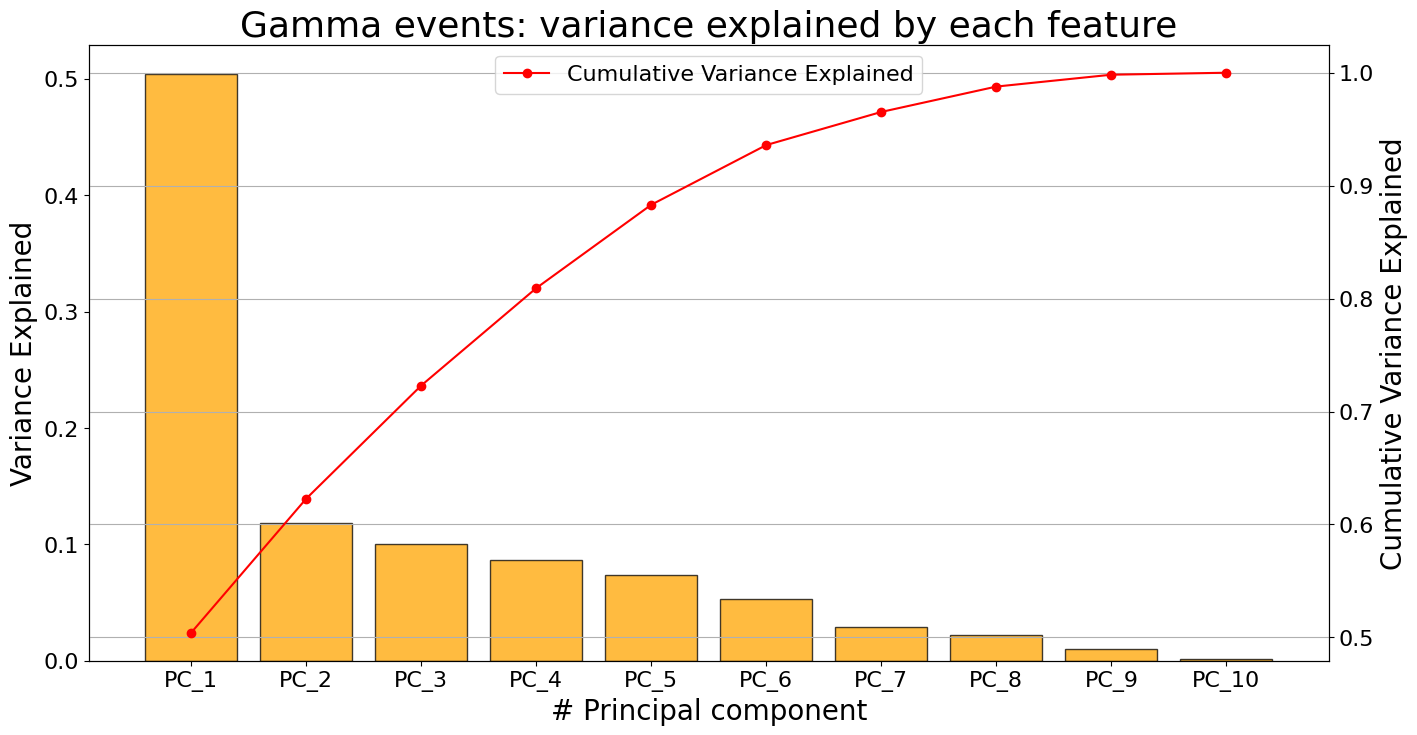

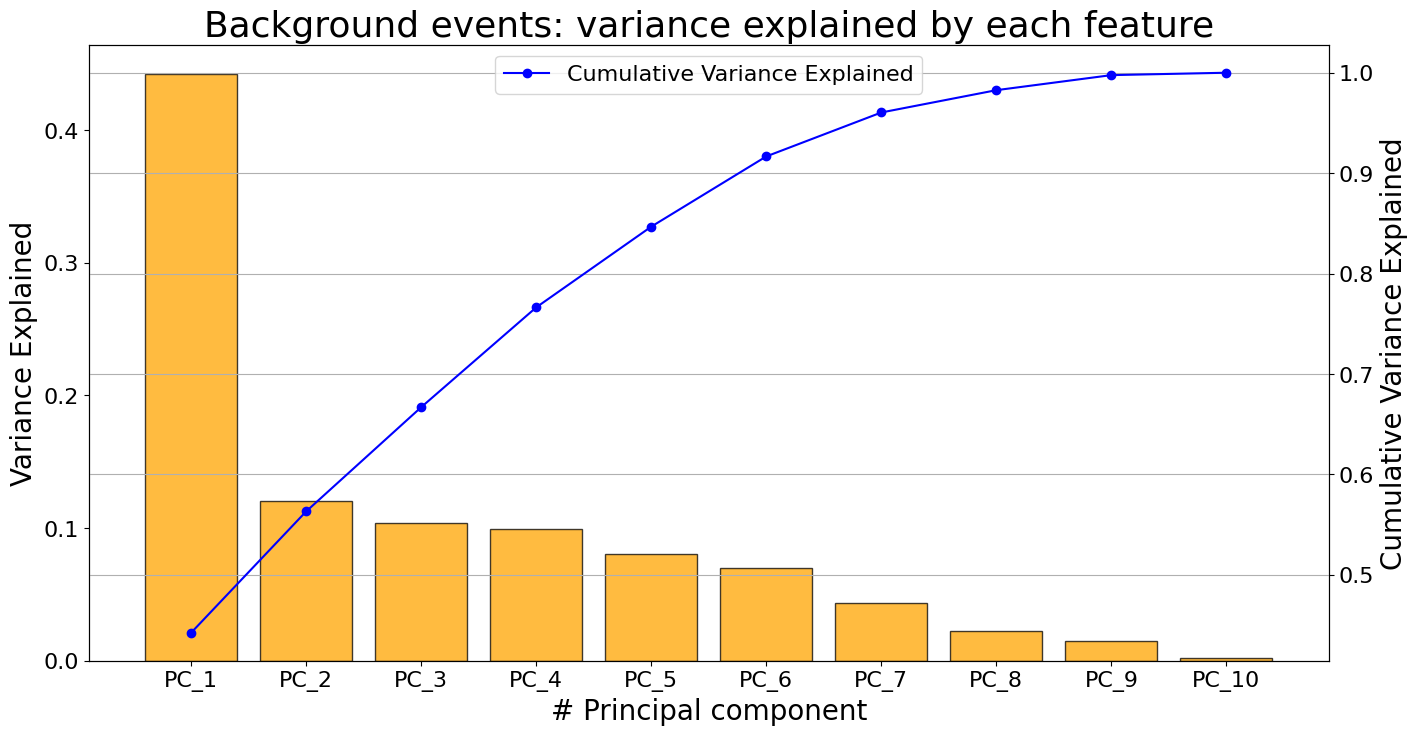

In [64]:
#GAMMA EVENTS
# sort eigenvalues in descending order and get sorted indices
sorted_indices = np.argsort(l_1)[::-1]
l_sorted = l_1[sorted_indices]

variance_explained = l_sorted / np.sum(l_sorted) # ratio of the variance of the data explained by each feature

# cumulative variance explained
cumulative_variance = np.cumsum(variance_explained)

feature_names = df_1.columns.tolist()
pca_list = []
for i in range(len(feature_names)):
    pca_list.append(f'PC_{i+1}')

# features ordered from most important to least important to variability
top_features = []
for i in range(len(feature_names)):
    most_important_feature_idx = sorted_indices[i]  # Index of the feature with the largest eigenvalue
    top_features.append(feature_names[most_important_feature_idx])

fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(pca_list, variance_explained, color='Orange', edgecolor='black',alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(pca_list, cumulative_variance, label='Cumulative Variance Explained', marker='o', color='red')

ax1.set_ylabel('Variance Explained',fontsize=20)
ax2.set_ylabel('Cumulative Variance Explained',fontsize=20)
ax1.set_xlabel('# Principal component',fontsize=20)

plt.title('Gamma events: variance explained by each feature',fontsize=26)
ax2.legend(loc='upper center',fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=45)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
plt.grid()
plt.show()
print("\n")

#BACKGROUND EVENTS
sorted_indices = np.argsort(l_0)[::-1]
l_sorted = l_0[sorted_indices]

variance_explained = l_sorted / np.sum(l_sorted) # ratio of the variance of the data explained by each feature

# cumulative variance explained
cumulative_variance = np.cumsum(variance_explained)

feature_names = df_0.columns.tolist()

# features ordered from most important to least important to variability
top_features = []
for i in range(len(feature_names)):
    most_important_feature_idx = sorted_indices[i]  # index of the feature with the largest eigenvalue
    top_features.append(feature_names[most_important_feature_idx])

fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(pca_list, variance_explained, color='Orange', edgecolor='black',alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(pca_list, cumulative_variance, label='Cumulative Variance Explained', marker='o', color='blue')

ax1.set_ylabel('Variance Explained',fontsize=20)
ax1.set_xlabel('# Principal component',fontsize=20)
ax2.set_ylabel('Cumulative Variance Explained',fontsize=20)


plt.title('Background events: variance explained by each feature',fontsize=26)
ax2.legend(loc='upper center',fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=18)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
plt.grid()
plt.show()

We notice that, for both signal and background events, the first principal component contributes to about half of the variabiality of the dataset, while the least 4 components account for less than 5%. However, it is not possible to identify on which basis it is convenient to work (the eigenvectors of signal or hadron events). For this reason and also beacuse of the limited number of features of the dataset, we decide to perform the following classification analysis with the complete dataset of features.

# Part 5: Machine Learning Analysis

In this section we are going to implement several ML binary classification algorithms to distinguish between gamma and hadron events. We choose as objective for each model to maximize the ROC curve area in the False Positive Rate (FPR) range [0-0.2]. We will not be using the fAlpha feature to train the models at this stage; it will be considered separately as a special feature in a later analysis.

The ROC curve plots the TPR, i.e: the fraction of actual gamma samples correctly identified as gamma, versus the False Positive Rate (FPR), i.e: the fraction of actual hadrons events incorrectly classified as gamma by the model. To do so, it's necessary to estimate a probability for the predicted class, not just to assign the predicted label. We will call *gammaness* the probability returned by each prediction model for a certain event to be a gamma event. Imposing different threshold values on the gammaness for the acceptance of an event as either gamma or hadron, we can obtain the ROC curve. The Area Under the ROC Curve (AUC) represents the overall probability that the model will distinguish between the two classes. However, in our case we are mostly interested in avoiding false positives, we do not really care about loss minimization per se or about the model performance at high FPR. This is the reason why we choose to maximize the partial AUC in a region that is a better indicator of how well the model performs for our specific needs.
For each model, when needed, we implement a grid search on the hyperparameters using the K-fold cross validation tecnique on the training set. The best model will be the one maximizing the average partial ROC area over the K configurations.

Another metric we will be using in the following analysis is the quality factor $Q=\frac{\epsilon_{\gamma}}{\sqrt{\epsilon_h}}$, where ${\epsilon_{\gamma}}$ represents the fraction of correctly classified signals (TPR), and ${{\epsilon_h}}$ represents the fraction of hadrons incorrectly classified as gammas (FPR). Our objective is to minimize the false positives while correctly identifying signals, which correpsonds to maximizing Q.  

## Part 5.1: Perceptron
First, we try to implement a simple linear classification model with the Perceptron algorithm. We associate label +1 to gamma events and -1 to hadron events. We randomly split the dataset into training and test set (80% and 20% of total data respectively).

In [65]:
# Alpha has not to be normalized (reset to original value)
X_rescaled['fAlpha'] = original_alpha.copy()

new_Y = []

# gammas are +1, hadrons are -1
for i in range(len(Y)):
    if (Y.iloc[i] == 'g'):
        new_Y.append(1)
    if(Y.iloc[i] == 'h'):
        new_Y.append(-1)

Y_df = pd.DataFrame({'category' : new_Y})
data_rescaled_and_indexed = pd.merge(X_rescaled, Y_df,left_index=True, right_index=True)

# divide dataset in 5 parts, taking 1 as test set ( 20 % )
# remove alpha
parts_to_be_split = 5
train_set, test_set = split_train_test_set( data_rescaled_and_indexed , parts_to_be_split )
train_alpha = train_set['fAlpha']
train_set = train_set.drop('fAlpha',axis=1)
test_alpha = test_set['fAlpha']
test_set = test_set.drop('fAlpha',axis=1)
X_train, Y_train = split_X_Y(train_set)
X_test, Y_test = split_X_Y(test_set)

print('Train set shapes:',np.shape(X_train),np.shape(Y_train))
print('Absolute and relative frequence of points in Training set:')
print(f'Signal: {len(Y_train[Y_train == 1])} points \t {round(len(Y_train[Y_train == 1])/len(Y_train)*100,2)}%')
print(f'Back: {len(Y_train[Y_train == -1])} points \t {round(len(Y_train[Y_train == -1])/len(Y_train)*100,2)}%\n')

print('Test set shapes:',np.shape(X_test),np.shape(Y_test))
print('Absolute and relative frequence of points in Test set:')
print(f'Signal: {len(Y_test[Y_test == 1])} points \t {round(len(Y_test[Y_test == 1])/len(Y_test)*100,2)}%')
print(f'Back: {len(Y_test[Y_test == -1])} points \t {round(len(Y_test[Y_test == -1])/len(Y_test)*100,2)}%\n')


Train set shapes: (15216, 9) (15216,)
Absolute and relative frequence of points in Training set:
Signal: 9859 points 	 64.79%
Back: 5357 points 	 35.21%

Test set shapes: (3803, 9) (3803,)
Absolute and relative frequence of points in Test set:
Signal: 2472 points 	 65.0%
Back: 1331 points 	 35.0%



The following cell performs the training. We train 1000 perceptrons algorithms to find the best performance achievable by the model.  

In [66]:
n_attempts = 1000
limit = 0.2
best_scores = []
best_f = []
best_t = []
best_score = 0

# K fold definition
K = 5
limit = 0.2
kf = KFold(n_splits=K, shuffle=True, random_state=42)

#print('n_iter, score')
for i in range (n_attempts):
    auc_fold = 0
    filtered_auc_fold = 0

    state = abs(np.random.normal(size=1))
    state = int(state[0] * 1000000)
    perceptron = Perceptron(alpha=0.01,penalty='l2',max_iter=10000,tol=1e-4,random_state=state,n_iter_no_change=10)

    for train_idx, val_idx in kf.split(data_rescaled_and_indexed):  ###gets the index of training and validation set

        train_K=data_rescaled_and_indexed.iloc[train_idx]
        valid_K=data_rescaled_and_indexed.iloc[val_idx]
        X_train_K, Y_train_K = split_X_Y(train_K)
        X_valid_K, Y_valid_K = split_X_Y(valid_K)


        fitted = perceptron.fit(X_train_K,Y_train_K)

        decision_values = perceptron.decision_function(X_valid_K)

        fpr, tpr, thresholds = roc_curve(Y_valid_K, decision_values)

        # here i filter data to compute roc curve area for fpr in range 0 -> 0.8
        fpr_filtered = fpr[fpr <= limit]
        tpr_filtered = tpr[:len(fpr_filtered)]

        auc_filtered_K = np.trapz(tpr_filtered, fpr_filtered)
        auc_K = roc_auc_score(Y_valid_K, decision_values)
        auc_fold += auc_K / K
        filtered_auc_fold += auc_filtered_K / K

    # score is better if filtered is better, though saving all
    if (filtered_auc_fold > best_score):
        best_score = filtered_auc_fold
        best_scores.append(auc_fold)

        #best_f.append(fpr)
        best_fpr = fpr
        best_tpr = tpr
        #best_t.append(tpr)
        best_perceptron = perceptron
        print('New best model found at iter',i,'out of',n_attempts)
        print('Partial AUC:',round(filtered_auc_fold,3),'Total AUC:', round(auc_fold,3),'\n')

print('Trained',n_attempts,'perceptrons')
print("best AUC-ROC Filtered Score:",round(best_score,3),"with total AUC-ROC Score:", round(best_scores[len(best_scores)-1],3) )

New best model found at iter 0 out of 1000
Partial AUC: 0.067 Total AUC: 0.68 

New best model found at iter 1 out of 1000
Partial AUC: 0.085 Total AUC: 0.805 

New best model found at iter 18 out of 1000
Partial AUC: 0.085 Total AUC: 0.795 

New best model found at iter 27 out of 1000
Partial AUC: 0.087 Total AUC: 0.794 

New best model found at iter 307 out of 1000
Partial AUC: 0.087 Total AUC: 0.795 

New best model found at iter 467 out of 1000
Partial AUC: 0.087 Total AUC: 0.794 

New best model found at iter 574 out of 1000
Partial AUC: 0.089 Total AUC: 0.797 

Trained 1000 perceptrons
best AUC-ROC Filtered Score: 0.089 with total AUC-ROC Score: 0.797


Here we plot the confusion matrix for the best model:

In [67]:
def normalize_cm(cm):
    norm_cm = np.zeros(shape=(2,2))
    bkg = cm[0,0] + cm[0,1]  # first row is bkg
    sig = cm[1,0] + cm[1,1]  # second row is signal
    norm_cm[0,0] = round(cm[0,0] / bkg,3)
    norm_cm[0,1] = round(cm[0,1] / bkg,3)
    norm_cm[1,0] = round(cm[1,0] / sig,3)
    norm_cm[1,1] = round(cm[1,1] / sig,3)

    return norm_cm


def plot_cm(cm,method_name):
    fig = plt.figure()
    im = plt.imshow(cm, cmap='seismic',alpha=0.8, interpolation='nearest')
    plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0,fontsize=12)
    plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0,fontsize=12)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = plt.text(j, i, format(cm[i, j], fmt),
            ha="center", va="center",
            color="white")
            text.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground='black')])

    fig.tight_layout()
    fig.colorbar(im, location = 'right')

    plt.xlabel('predicted label',fontsize=14)
    plt.ylabel('true label',fontsize=14)

    plt.title(f'{method_name} confusion matrix',fontsize=16)
    plt.show()

In [68]:
model = best_perceptron
best_perceptron.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

cm = sklearn.metrics.confusion_matrix(Y_test,Y_pred)


Confusion matrix:
[[0.358 0.642]
 [0.243 0.757]]


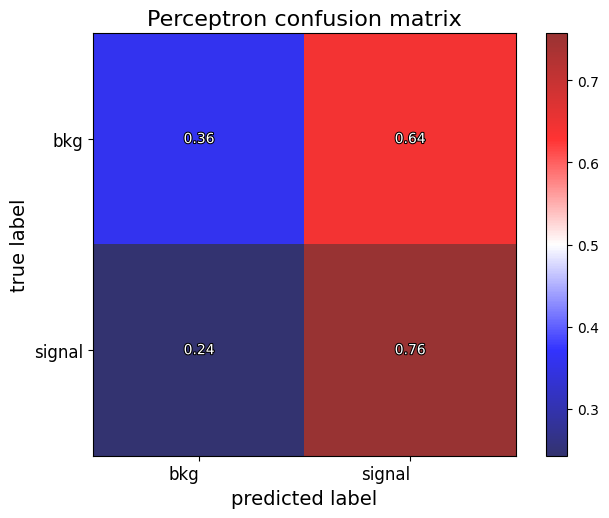

In [69]:
perceptron_cm = normalize_cm(cm)

print('Confusion matrix:')
print(perceptron_cm)
plot_cm(perceptron_cm,method_name='Perceptron')


In the end we plot the ROC curve obtained and determine the Q value of the best model. We save it in a variable that will be used later as confrontation.

In [70]:
def plot_roc(fpr,tpr,auc,method_name,color):
    limit = 0.2
    fpr_filtered = fpr[fpr <= limit]
    tpr_filtered = tpr[:len(fpr_filtered)]

    auc_thresh = np.trapz(tpr_filtered, fpr_filtered)

    idx = np.argmax(fpr > limit) - 1
    fpr_thresh = fpr[idx]
    tpr_thresh = tpr[idx]
    #print(fpr_thresh,tpr_thresh)

    fig = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})',c=color)
    #plt.scatter(fpr_thresh,tpr_thresh,c='red')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.fill_between(fpr[:idx+1], tpr[:idx+1], color=color,alpha=0.2, label= f'Partial ROC (Partial AUC = {auc_thresh:.3f})')
    plt.axvline(x=fpr_thresh, ymin=-0.05, ymax=tpr_thresh-0.02, color='green', linestyle='--', label='FPR = 0.2')
    plt.axhline(y=tpr_thresh, xmin=-0.05, xmax=fpr_thresh+0.025, color='green', linestyle='--')

    plt.title(f'{method_name} ROC Curve',fontsize=16)
    plt.xlabel('False Positive Rate (FPR)',fontsize=14)
    plt.ylabel('True Positive Rate (TPR)',fontsize=14)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(loc='lower right',fontsize=11)
    plt.grid(True)
    plt.show();

Perceptron Q value: 0.945


<Figure size 800x600 with 0 Axes>

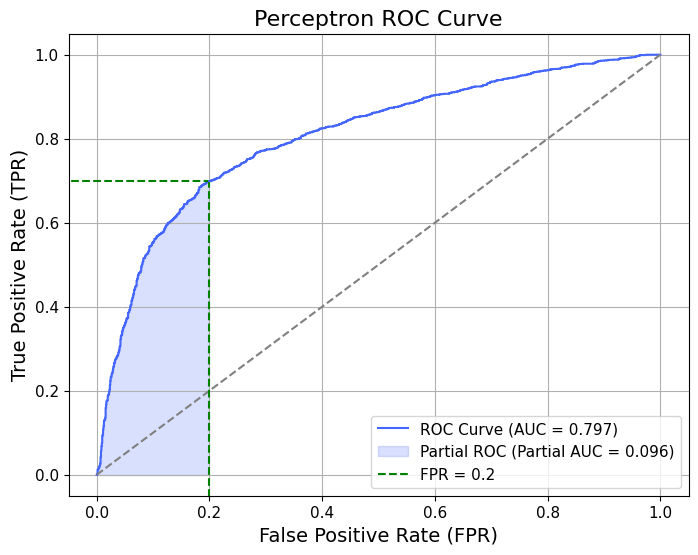

In [71]:
fig = plt.figure(figsize=(8, 6))

fpr_perceptron = best_fpr
tpr_perceptron = best_tpr

Q_perceptron = perceptron_cm[1][1]/ np.sqrt(perceptron_cm[0][1])
print('Perceptron Q value:',round(Q_perceptron,3))

plot_roc(fpr_perceptron,tpr_perceptron,best_scores[len(best_f)-1],"Perceptron","#4466fc");


## Part 5.2: Logistic Regression

Logistic regression allows to pose a classification problem as a regression problem, where the predicted label is the probability for a sample to belong to a certain class. Thus, in our case the output of the algorithm is the *gammaness*. We can then choose a threshold for the *gammaness* to assign gamma (+1) as the predicted label. The learning problem is to find the sigmoid function
$\sigma_{\mathbf{w}}(\mathbf{x}) =\frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x})}}$
that minimizes the loss:

$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) + \lambda||\mathbf{w}||^2
$$
where:
$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) = -\sum_{i=1}^{n} \left[ y_i \log(\sigma_{\mathbf{w}}(\mathbf{x}_i)) + (1 - y_i) \log(1 - \sigma_{\mathbf{w}}(\mathbf{x}_i)) \right]$$
and we use the Tikhonov regularization technique to prevent overfitting.

To find the best hyper-parameter $C=\frac{1}{\lambda}$ for model we choose the usual 0.5 threshold for the *gammaness* and perform a K-fold cross validation, where again we keep as best model the one that maximizes the partial AUC.

In [72]:
# this function determines the partial area under the curve, up to FPR<=0.2

def partial_auc_at_fpr(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    valid_indices = fpr <= 0.2
    partial_fpr = fpr[valid_indices]
    partial_tpr = tpr[valid_indices]
    # check if there are at least 2 points for partial AUC calculation
    if len(partial_fpr) < 2:
        return 0  # return 0 if not enough points to calculate AUC

    partial_auc = auc(partial_fpr, partial_tpr)
    return partial_auc

def full_auc_scorer(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return auc(fpr, tpr)

# create scoring function to implement a grid-search
partial_auc_scorer = make_scorer(partial_auc_at_fpr, greater_is_better=True)


In [73]:
auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict')

# hyper-parameters
param_grid = {'C': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]} # we use Tikhonov regularization: in the loss we add a term proportional to the norm squared of w (C=1/lambda)

# grid search with K-fold validation
K=5

fprs = []
tprs = []
aucs = []
partial_aucs = []
C = []
for c in param_grid['C']:
        auc_value=0
        partial_auc=0
        print(f"Training model with regularization constant c = {c}")
        C.append(c)
        for i in range(K):
            train_K, valid_K = split_train_test_set(train_set,K)
            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            model= LogisticRegression(penalty='l2',tol=1e-5,C=c,solver='lbfgs',max_iter=int(1e6)) # 'lbfgs' approximates up to the the second derivative of the loss function to optimize the coefficients, best for large datasets
            model.fit(X_train_K,Y_train_K)

            y_pred_proba = model.predict_proba(X_valid_K)[:, 1]
            fpr, tpr, _ = roc_curve(Y_valid_K, y_pred_proba)
            fprs.append(fpr)
            tprs.append(tpr)
            auc_value_k = auc(fpr, tpr)
            # keep fpr less than 0.2 (if not able to find it, partial auc is set to zero)
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc=0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += auc_value_k/K
        print('Partial AUC:', partial_auc)
        partial_aucs.append(partial_auc)
        print('AUC:', auc_value,'\n')
        aucs.append(auc_value)

Training model with regularization constant c = 0.001
Partial AUC: 0.04292617723470098
AUC: 0.7057026161531035 

Training model with regularization constant c = 0.005
Partial AUC: 0.043071339784735034
AUC: 0.7116073616613541 

Training model with regularization constant c = 0.01
Partial AUC: 0.043175556664864216
AUC: 0.712215304308487 

Training model with regularization constant c = 0.05
Partial AUC: 0.04494265515877264
AUC: 0.716446503716819 

Training model with regularization constant c = 0.1
Partial AUC: 0.044460899745074056
AUC: 0.7134732143358256 

Training model with regularization constant c = 0.5
Partial AUC: 0.04365263916929852
AUC: 0.7194013179362881 

Training model with regularization constant c = 1
Partial AUC: 0.04468566521774333
AUC: 0.7198634753160371 

Training model with regularization constant c = 5
Partial AUC: 0.04371351793994023
AUC: 0.7155765579893487 

Training model with regularization constant c = 10
Partial AUC: 0.04447635818105998
AUC: 0.7181244651695611 


In [74]:
best_partial_auc = np.max(np.array(partial_aucs))
best_auc= np.max(np.array(aucs))
best_index = np.where(partial_aucs==best_partial_auc)[0]
print('Best model with regularization constant c=',C[best_index[0]])
print('Best partial AUC (validation set):', best_partial_auc)
print('AUC of best model (validation set):', best_auc,'\n')

best_model = LogisticRegression(penalty='l2', C= C[best_index[0]],solver='lbfgs',max_iter=300)
best_model.fit(X_train,Y_train) # retrain the best
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(Y_test, y_pred_proba_test)
auc_test= auc(fpr_test,tpr_test)

partial_fpr_test = fpr_test[fpr_test <= 0.2]
if (len(partial_fpr_test)<2):
    partial_auc_test=0
else:
    partial_tpr_test = tpr_test[:len(partial_fpr_test)]
    partial_auc_test = auc(partial_fpr_test, partial_tpr_test)
print('Best Partial AUC (test set):', round(partial_auc_test,3))
print('AUC of best model (test set):', round(auc_test,3))

Best model with regularization constant c= 0.05
Best partial AUC (validation set): 0.04494265515877264
AUC of best model (validation set): 0.7203804094337969 

Best Partial AUC (test set): 0.044
AUC of best model (test set): 0.716


Confusion matrix:
[[0.35  0.65 ]
 [0.056 0.944]]


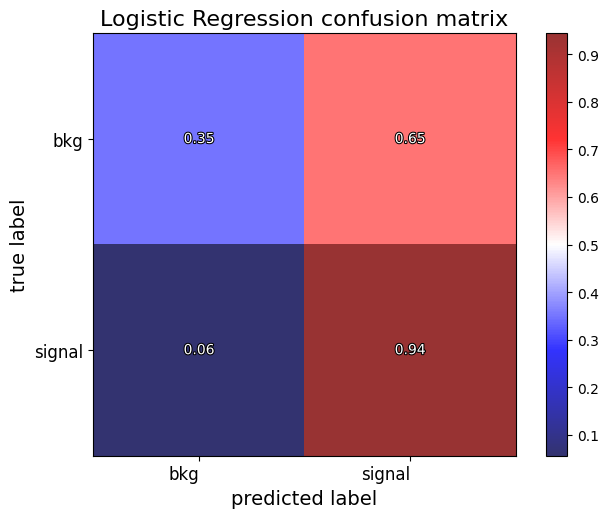

In [75]:
Y_pred = best_model.predict(X_test)
cm = sklearn.metrics.confusion_matrix(Y_test,Y_pred)
log_cm = normalize_cm(cm)

print('Confusion matrix:')
print(log_cm)
plot_cm(log_cm,method_name='Logistic Regression')


Here we plot the best model for ROC curve

Q value of best model: 1.1708878945221277


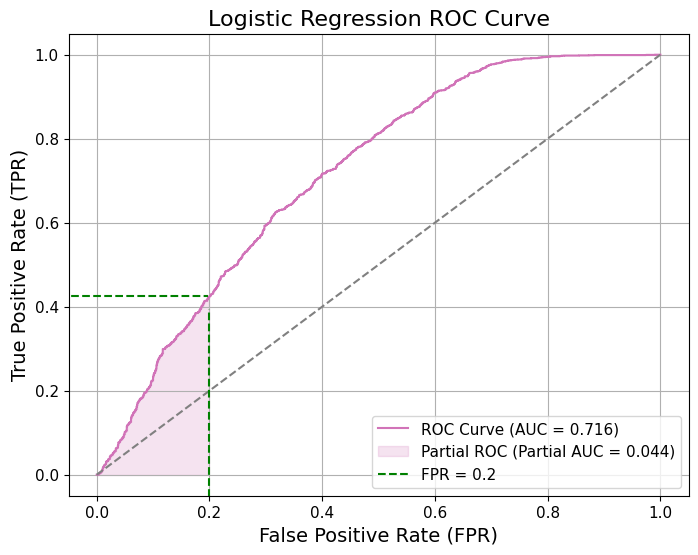

In [76]:
fpr_log = fpr_test
tpr_log = tpr_test
Q_log = log_cm[1][1]/ np.sqrt(log_cm[0][1])
print('Q value of best model:',Q_log)

plot_roc(fpr_log,tpr_log,auc_test,'Logistic Regression','#d173b8')


## Part 5.3: SVM
In this part we consider a soft SVM model. The hyperparameters to choose for the model are:

- the Kernel function: linear, polynomial with degree 3, RBF (Radial Basis Function) and sigmoid, which defines the shape of the boundary;
- the parameter $\nu$, which controls the size of the margin: a lower $\nu$ defines a model with a larger margin;
- the parameter $\gamma$, which controls how close to the training points the margin bends: low $\gamma$ values define a smooth, almost linear boundary, while high values define a fractal-like boundary.

In [77]:
alphaCol = data_rescaled_and_indexed['fAlpha']
data_rescaled_and_indexed = data_rescaled_and_indexed.drop('fAlpha',axis = 1)
print(np.shape(data_rescaled_and_indexed))

(19019, 10)


In [78]:
# list with all possible kernels (poly uses deg = 3 as standard value)
kernels = ['linear','poly','rbf','sigmoid']


# list with all nu values (upper bound on fraction of margin errors)
nus = [ 0.5 , 0.1 , 0.05 , 0.01 ]

# list with all gamma values (by default is 1/(n_features*X.var()) )
gammas = [ 0.1, 0.01, 0.001, 0.0001 ]

best_auc_score = 0

# tolerance for stopping criteria (default is 1e-3) (default max_iter is inf)
tolerance = 1e-6
max_iter = int(2e4)

# K fold definition
K = 5
limit = 0.2
kf = KFold(n_splits=K, shuffle=True, random_state=42)
kFoldInfo = 0

start_time = time()


for kernel_type in kernels:
    for nu in nus:
        for gamma in gammas:
            print(f'training SVM with {kernel_type} kernel, nu = {nu}, gamma = {gamma}...')
            partial_auc = 0
            auc_value = 0
            for train_idx, val_idx in kf.split(data_rescaled_and_indexed):  ###gets the index of training and validation set

                train_K=data_rescaled_and_indexed.iloc[train_idx]
                valid_K=data_rescaled_and_indexed.iloc[val_idx]
                X_train_K, Y_train_K = split_X_Y(train_K)
                X_valid_K, Y_valid_K = split_X_Y(valid_K)

                clf = make_pipeline(StandardScaler(), NuSVC(nu=nu,kernel=kernel_type,gamma=gamma,probability=True,tol=tolerance,max_iter=max_iter),verbose=False)

                fitted = clf.fit(X_train_K, Y_train_K)
                pred = clf.predict(X_valid_K)
                errors = np.sum(pred != Y_valid_K) / len(Y_valid_K)

                pred_prob = clf.predict_proba(X_valid_K)[:, 1]
                fpr, tpr, thresholds = roc_curve(Y_valid_K, pred_prob)

                auc_value_k = auc(fpr, tpr)
                fpr_filtered = fpr[fpr <= limit]

                if (len(fpr_filtered) < 2 ):
                    partial_auc=0
                else:
                    tpr_filtered = tpr[:len(fpr_filtered)]
                    partial_auc_k = np.trapz(fpr_filtered, tpr_filtered)
                partial_auc += partial_auc_k/K
                auc_value += auc_value_k/K
            if(partial_auc > best_auc_score):
                best_auc_score = partial_auc
                best_model = clf
                best_tpr = tpr
                best_fpr = fpr
                best_auc = auc_value
                best_kernel = kernel_type
                best_nu = nu
                best_gamma = gamma
            print('Resulting partial AUC:',partial_auc.round(3),"Resulting total AUC:",best_auc.round(3))
            print('elapsed time:',round(time()-start_time,3),'s \n')
            start_time = time()

print('best results are for')
print('kernel:',best_kernel,'nu:',best_nu,'gamma:',best_gamma,'with auc:',best_auc)


training SVM with linear kernel, nu = 0.5, gamma = 0.1...
Resulting partial AUC: 0.021 Resulting total AUC: 0.503
elapsed time: 221.18 s 

training SVM with linear kernel, nu = 0.5, gamma = 0.01...
Resulting partial AUC: 0.025 Resulting total AUC: 0.548
elapsed time: 228.669 s 

training SVM with linear kernel, nu = 0.5, gamma = 0.001...
Resulting partial AUC: 0.022 Resulting total AUC: 0.548
elapsed time: 223.812 s 

training SVM with linear kernel, nu = 0.5, gamma = 0.0001...
Resulting partial AUC: 0.026 Resulting total AUC: 0.559
elapsed time: 221.521 s 

training SVM with linear kernel, nu = 0.1, gamma = 0.1...
Resulting partial AUC: 0.017 Resulting total AUC: 0.559
elapsed time: 91.685 s 

training SVM with linear kernel, nu = 0.1, gamma = 0.01...
Resulting partial AUC: 0.021 Resulting total AUC: 0.559
elapsed time: 90.478 s 

training SVM with linear kernel, nu = 0.1, gamma = 0.001...
Resulting partial AUC: 0.027 Resulting total AUC: 0.585
elapsed time: 92.797 s 

training SVM wi

Here we have the confusion matrix

Confusion matrix:
[[0.518 0.482]
 [0.034 0.966]]


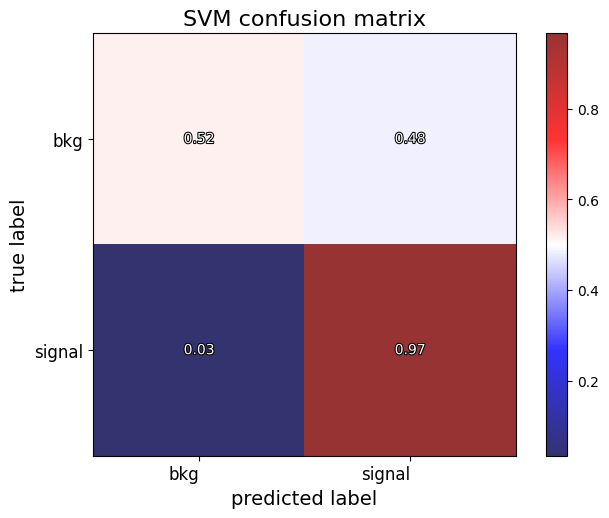

In [79]:
best_pred = best_model.predict(X_test)
cm = sklearn.metrics.confusion_matrix(Y_test,best_pred)
SVM_cm = normalize_cm(cm)

print('Confusion matrix:')
print(SVM_cm)
plot_cm(SVM_cm,method_name='SVM')


The best curve is then plotted and saved

best SVM Q value: 1.3914051526263609


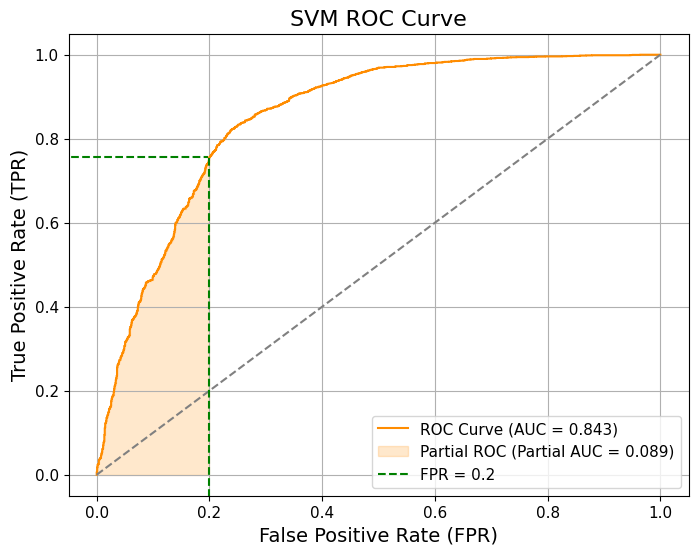

In [80]:
tpr_SVM = best_tpr
fpr_SVM = best_fpr
Q_SVM = get_best_Q(fpr_SVM,tpr_SVM)
Q_SVM = SVM_cm[1][1]/ np.sqrt(SVM_cm[0][1])


print('best SVM Q value:',Q_SVM)

plot_roc(fpr_SVM,tpr_SVM,best_auc,"SVM","darkorange")


## Part 5.4: Random Forest
Here we are going to implement a Random Forest classification algorithm. A Random Forest is composed of different decision tree predictors. For each tree, at each iteration, the data are split into two branches according to a threshold value for one of the features. At each split, the best feature and the best threshold value are chosen by minimizing the entropy function
𝐻 given by:
$$
\displaystyle H = - \sum_{i=+1,-1} f_i \log_2(f_i)
$$
where $f_i$ is the fraction of points of class $i=+1,-1$ in the training set. The splitting continues until either a maximum depth for the tree is reached, in which case the most frequent class of the branch is assigned to all points, or the points of the branch all belong to the same class (in this case the branch is called a leaf). Different trees are built by randomly drawing data with replacement from the test set, applying the algorithm to each tree. The final label for a point is chosen based on a majority vote of the trees results.

The hyperparameters of the model to choose are the ***number of trees*** and the ***maximum depth*** of the trees. Again we implement a K-fold cross validation to choose as best hyperparameters the ones that maximize the partial area under the ROC curve of the classifier. To build the ROC curve we need to estimate the probability for the points to belong to a certain class. This can be done because each tree, at the last decision step, assigns a class label based on the majority class of the training samples that reached that final leaf node, but also keeps track of the proportion of the classes in that leaf node. For example, suppose a test point ends up in a leaf node where, out of 100 training samples that ended up there, 80 belonged to class 1 and 20 belonged to class -1. The *gammaness* of the point would be 0.8, while the probability of it belonging to class -1 would be 0.2.

We will use the class `RandomForestClassifier` from `scikit-learn` to implement and train the Forest and to predict the labels with their probabilities.   

In [86]:
from time import time

num_trees= np.arange(40,300,10)
max_depth= np.arange(10,40,2)
accuracies=[]
roc_areas=[]
best_area=0
best_acc=0
best_model= [] # stores best number of trees and best max depth
partial_aucs = []
total_aucs = []

start_time = time()

max_iter = len(num_trees) * len(max_depth)
iteration = 0

for tree in num_trees:
    for depth in max_depth:
        print('Training model with number of trees:',tree,', Maximum depth',depth,':')
        partial_auc = 0
        auc_value = 0
        accuracy = 0

        forest = RandomForestClassifier(n_estimators=tree,  # number of trees
                                           max_depth= depth,
                                           max_features=X_train.shape[1],   # number of features for each split (random subset)
                                           bootstrap=True,    # bagging (sampling with replacement)
                                           max_samples=1.0,   # percentage of samples to use for each tree (100% of data)
                                           random_state=10,
                                           n_jobs=-1)
        # train each model, predict labels and probability of each label
        forest.fit(X_train, Y_train)
        Y_pred = forest.predict(X_test)
        y_pred_prob = forest.predict_proba(X_test)[:, 1] # probability for the test points to belong to class +1 or -1
        # accuracy on test set
        accuracy = accuracy_score(Y_test, Y_pred)


        # false positive rates and the true positive rates for different threshold values
        fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

        # area under the ROC curve on test set
        roc_auc = auc(fpr, tpr)
        roc_areas.append(roc_auc)

        partial_fpr = fpr[fpr <= 0.2]
        if (len(partial_fpr) < 2 ):
            partial_auc = 0
        else:
            partial_tpr = tpr[:len(partial_fpr)]
            partial_auc = auc(partial_fpr, partial_tpr)

        partial_aucs.append(partial_auc)

        if(partial_auc>best_area):
            best_area = partial_auc
            best_total_auc = roc_auc
            best_acc= accuracy
            best_model=[tree,depth]
            new_best = True
        iteration +=1
        print(f'elapsed time: {round(time()-start_time,2)}s, done {iteration} out of {max_iter}')
        if (new_best == True):
            new_best = False
            print('\033[91mArea under ROC curve:',round(roc_auc,3),'Selected area:',round(partial_auc,3),'\033[0m')

        else:
            print('Area under ROC curve:',round(roc_auc,3),'Selected area:',round(partial_auc,3))
        print('\n')

print('Best number of trees:', best_model[0],'\n')
print('Best maximum depth:', best_model[1],'\n')
print('Partial AUC of best model:',round(best_area,3))
print('Total AUC of best model:',round(best_total_auc,3))


Training model with number of trees: 40 , Maximum depth 10 :
elapsed time: 8.1s, done 1 out of 390
Area under ROC curve: 0.856 Selected area: 0.093 


Training model with number of trees: 40 , Maximum depth 12 :
elapsed time: 13.52s, done 2 out of 390
Area under ROC curve: 0.869 Selected area: 0.101 


Training model with number of trees: 40 , Maximum depth 14 :
elapsed time: 19.16s, done 3 out of 390
Area under ROC curve: 0.873 Selected area: 0.103 


Training model with number of trees: 40 , Maximum depth 16 :
elapsed time: 25.09s, done 4 out of 390
Area under ROC curve: 0.874 Selected area: 0.104 


Training model with number of trees: 40 , Maximum depth 18 :
elapsed time: 31.06s, done 5 out of 390
Area under ROC curve: 0.876 Selected area: 0.105 


Training model with number of trees: 40 , Maximum depth 20 :
elapsed time: 38.17s, done 6 out of 390
Area under ROC curve: 0.876 Selected area: 0.104


Training model with number of trees: 40 , Maximum depth 22 :
elapsed time: 44.74s, do

Now we train again the best Random Forest found on the whole training set and calculate the partial AUC of the best model.  

In [87]:
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)
X_test_np = np.array(X_test)
Y_test_np = np.array(Y_test)

best_forest = RandomForestClassifier(n_estimators=best_model[0], max_depth= best_model[1], max_features=X_train_np.shape[1],bootstrap=True,max_samples=1.0,random_state=10,n_jobs=-1)

best_forest.fit(X_train_np,Y_train_np)
Y_pred = best_forest.predict(X_test_np)
accuracy = accuracy_score(Y_test_np, Y_pred)
print('Accuracy of best Random Forest:',round(accuracy,3))

y_pred_prob = best_forest.predict_proba(X_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test_np, y_pred_prob)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[:len(partial_fpr)]
partial_auc = auc(partial_fpr, partial_tpr)
roc_auc_best = auc(fpr, tpr)
print('Partial AUC of the best Random Forest (Test set):',round(partial_auc,3))
print('AUC of the best Random Forest (Test set):',round(roc_auc_best,3))



Accuracy of best Random Forest: 0.829
Partial AUC of the best Random Forest (Test set): 0.107
AUC of the best Random Forest (Test set): 0.878


Here we plot the confusion matrix:

Confusion matrix:
[[0.639 0.361]
 [0.065 0.935]]


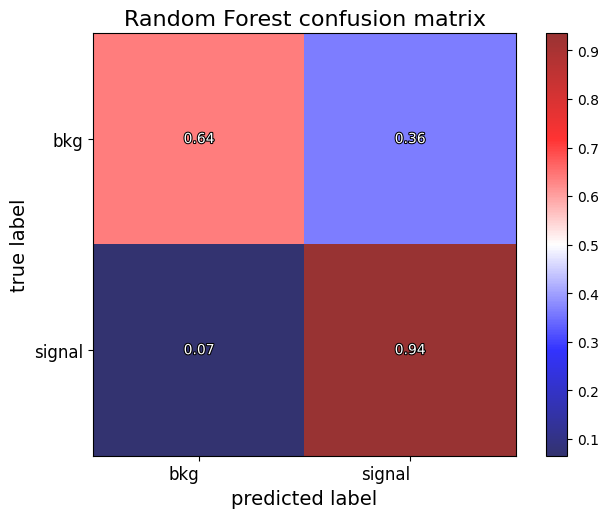

In [114]:
cm = sklearn.metrics.confusion_matrix(Y_test,Y_pred)
RF_cm = normalize_cm(cm)

print('Confusion matrix:')
print(RF_cm)
plot_cm(RF_cm,method_name='Random Forest')


Finally we compute the *Q* value of the best Forest on the test set and plot the ROC curve of the relative algorithm.

Best Random Forest Q: 1.556


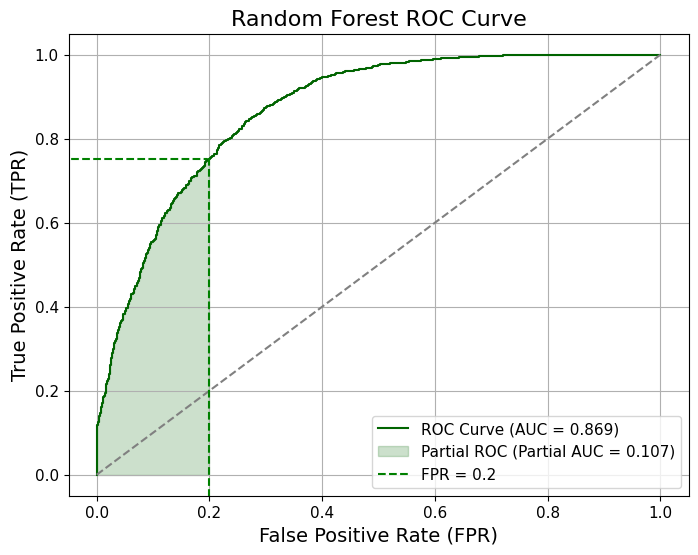

In [13]:
fpr_rforest = fpr
tpr_rforest = tpr
Q_rforest = RF_cm[1][1]/ np.sqrt(RF_cm[0][1])

print('Best Random Forest Q:',round(Q_rforest,3))

idx = np.argmax(fpr_rforest > 0.2) - 1
fpr_thresh = fpr_rforest[idx]
tpr_thresh = tpr_rforest[idx]

#plot_roc(fpr_rforest,tpr_rforest,roc_auc_best,"Random forest","darkgreen")
fig = plt.figure(figsize=(8, 6))
plt.plot(fpr_rforest, tpr_rforest, label=f'ROC Curve (AUC = {round(roc_auc_best,3)})',c='darkgreen')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # (random classifier)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
#plt.fill_between(fpr_thresh[:idx+1],tpr_thresh[:idx+1],color='darkgreen',alpha=0.2, label=f'Partial ROC (Partial AUC = {round(partial_auc,3)})')
plt.fill_between(fpr_rforest[:idx+1], tpr_rforest[:idx+1], color='darkgreen', alpha=0.2,
                 label=f'Partial ROC (Partial AUC = 0.107)')

plt.axvline(x=fpr_thresh, ymin=-0.05, ymax=tpr_thresh-0.02, color='green', linestyle='--', label='FPR = 0.2')
plt.axhline(y=tpr_thresh, xmin=-0.05, xmax=fpr_thresh+0.025, color='green', linestyle='--')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.xlabel('False Positive Rate (FPR)',fontsize=14)
plt.ylabel('True Positive Rate (TPR)',fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(loc='lower right',fontsize=11)
plt.grid(True)
plt.show();


## Part 5.5: FFNN
In this section we implement a Feedforward Fully connected Neural Network as a classification algorithm. The hyperparameters to choose to tailor the NN are its architecture, i.e. the  ***number of layers*** and the ***number of neurons*** in each layer, and the ***initial learning rate*** to update weights using *Stochastic Gradient Descent* (SGD) during loss minimization. We choose as activation function for each layer the *ReLu* function (common choice) and an adaptive learning rate over the iterations.  

In [101]:

# redefine NN cycle
hidden_layer_sizes = [(18,), (36,), (54,), (36,18), (54,18), (54,36), (54,36,18)]
learning_rate_init = [ 0.1 , 0.01 , 0.001 ]

start_time = time()

auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict' )

parameters = []
fprs = []
tprs = []
aucs = []
partial_aucs = []
hls = []
lrs = []
models = []
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

for size in hidden_layer_sizes:
    for lr in learning_rate_init:
        print(f"Training MLP of size {size} and lr {lr}...")
        #print("Validation AUC \t Partial AUC")
        lrs.append(lr)
        hls.append(size)
        partial_auc = 0
        auc_value = 0

        for i, (train_idx, val_idx) in enumerate(kf.split(X)):

            #print(f" Fold n. {i}")
            train_K=data_rescaled_and_indexed.iloc[train_idx]
            valid_K=data_rescaled_and_indexed.iloc[val_idx]
            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)

            MLP = MLPClassifier(hidden_layer_sizes=size,
                                activation='relu',
                                max_iter=1000,
                                alpha=1e-4,
                                solver='adam',
                                tol=1e-5,
                                learning_rate='adaptive',
                                learning_rate_init=lr,
                                verbose=0)

            MLP.fit(X_train_K,Y_train_K)
            parameters.append(MLP.coefs_)
            models.append(MLP)

            y_pred_proba = MLP.predict_proba(X_valid_K)[:, 1]

            fpr, tpr, _ = roc_curve(Y_valid_K, y_pred_proba)
            fprs.append(fpr)
            tprs.append(tpr)
            auc_value_k = auc(fpr, tpr)


            # search for fpr less than 0.2 (if not able fpr is set to zero)
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc = 0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)

            #print(f"Fold {i+1}:", round(auc_value_k,3),f"\t",round(partial_auc_k,3))
            partial_auc += partial_auc_k/K
            auc_value += auc_value_k/K
        partial_aucs.append(partial_auc)
        aucs.append(auc_value)

        elapsed_time = time() - start_time
        start_time = time()
        print(f"Time needed for training: {elapsed_time:.2f} seconds")
        print("total AUC:",round(auc_value,3),"\t partial AUC:",round(partial_auc,3),'\n')
        print('\n')

best_index_thresh = np.argmax(np.array(partial_aucs))
best_partial_auc_thresh = partial_aucs[best_index_thresh]
best_auc_thresh = aucs[best_index_thresh]

best_model_NN = models[best_index_thresh]
best_lr = lrs[best_index_thresh]
best_size = hls[best_index_thresh]

print(f"Best Learning Rate: {best_lr}, Best Hidden Layer Size: {best_size}")
print(f"Partial AUC of best model: {round(best_partial_auc_thresh,3)}")
print(f"AUC of best model: {round(best_auc_thresh,3)}")

Training MLP of size (18,) and lr 0.1...
Time needed for training: 5.85 seconds
total AUC: 0.852 	 partial AUC: 0.091 



Training MLP of size (18,) and lr 0.01...
Time needed for training: 18.27 seconds
total AUC: 0.868 	 partial AUC: 0.1 



Training MLP of size (18,) and lr 0.001...
Time needed for training: 68.20 seconds
total AUC: 0.864 	 partial AUC: 0.098 



Training MLP of size (36,) and lr 0.1...
Time needed for training: 5.91 seconds
total AUC: 0.854 	 partial AUC: 0.093 



Training MLP of size (36,) and lr 0.01...
Time needed for training: 31.85 seconds
total AUC: 0.878 	 partial AUC: 0.105 



Training MLP of size (36,) and lr 0.001...
Time needed for training: 73.79 seconds
total AUC: 0.868 	 partial AUC: 0.1 



Training MLP of size (54,) and lr 0.1...
Time needed for training: 7.26 seconds
total AUC: 0.855 	 partial AUC: 0.092 



Training MLP of size (54,) and lr 0.01...
Time needed for training: 29.93 seconds
total AUC: 0.878 	 partial AUC: 0.105 



Training MLP of 

Here we train again the best model on all the training set. Then we test its performance on the test set and plot the ROC curve as well as the confusion matrix.

In [119]:
best_model_NN.fit(X_train_np,Y_train_np)
y_pred_prob = best_model_NN.predict_proba(X_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test_np, y_pred_prob)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[:len(partial_fpr)]
partial_auc = auc(partial_fpr, partial_tpr)
roc_auc_best = auc(fpr, tpr)
print('Partial AUC of the best NN (Test set):',round(partial_auc,3))
print('AUC of the best NN (Test set):',round(roc_auc_best,3))

Partial AUC of the best NN (Test set): 0.102
AUC of the best NN (Test set): 0.869


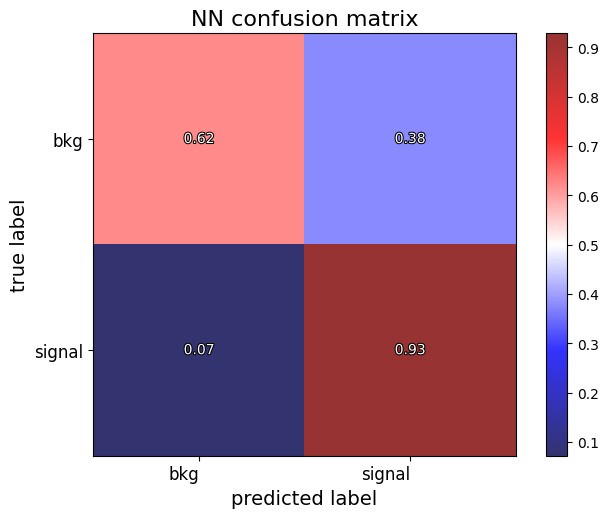

In [120]:
#print(best_model)
Y_pred = best_model_NN.predict(X_test_np)
cm = sklearn.metrics.confusion_matrix(Y_test_np,Y_pred)
NN_cm = normalize_cm(cm)

plot_cm(NN_cm,method_name='NN')


Best NN Q value: 1.511


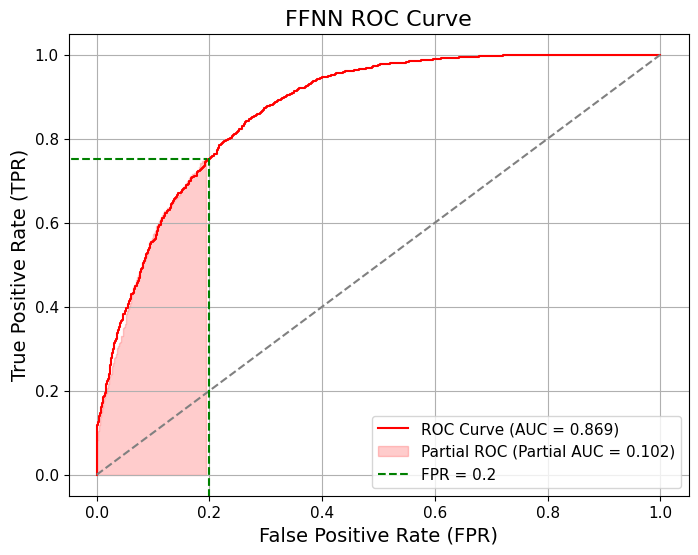

In [121]:
Q_NN = NN_cm[1][1]/ np.sqrt(NN_cm[0][1])

fpr_NN = fpr
tpr_NN = tpr

print('Best NN Q value:',round(Q_NN,3))

idx = np.argmax(fpr_NN > 0.2) - 1
fpr_thresh = fpr_NN[idx]
tpr_thresh = tpr_NN[idx]

fig = plt.figure(figsize=(8, 6))
plt.plot(fpr_NN,tpr_NN, label=f'ROC Curve (AUC = {round(roc_auc_best,3)})',c='red')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # (random classifier)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
#plt.fill_between(best_fpr_thresh[:idx+1], best_tpr_thresh[:idx+1],color='red',alpha=0.2, label=f'Partial ROC (Partial AUC = {round(partial_auc,3)})')
plt.fill_between(fpr_rforest[:idx+1], tpr_rforest[:idx+1],color='red',alpha=0.2, label=f'Partial ROC (Partial AUC = {round(partial_auc,3)})')
plt.axvline(x=fpr_thresh, ymin=-0.05, ymax=tpr_thresh-0.02, color='green', linestyle='--', label='FPR = 0.2')
plt.axhline(y=tpr_thresh, xmin=-0.05, xmax=fpr_thresh+0.025, color='green', linestyle='--')
plt.title(f'FFNN ROC Curve',fontsize=16)
plt.xlabel('False Positive Rate (FPR)',fontsize=14)
plt.ylabel('True Positive Rate (TPR)',fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(loc='lower right',fontsize=11)
plt.grid(True)
plt.show()

Now we plot the ROC curves of all algorithms for visual comparison:

best NN Q value: 1.511
best perceptron Q value: 0.945
best SVM Q value: 1.391
best random forest Q value: 1.556
best log_reg Q value: 1.171


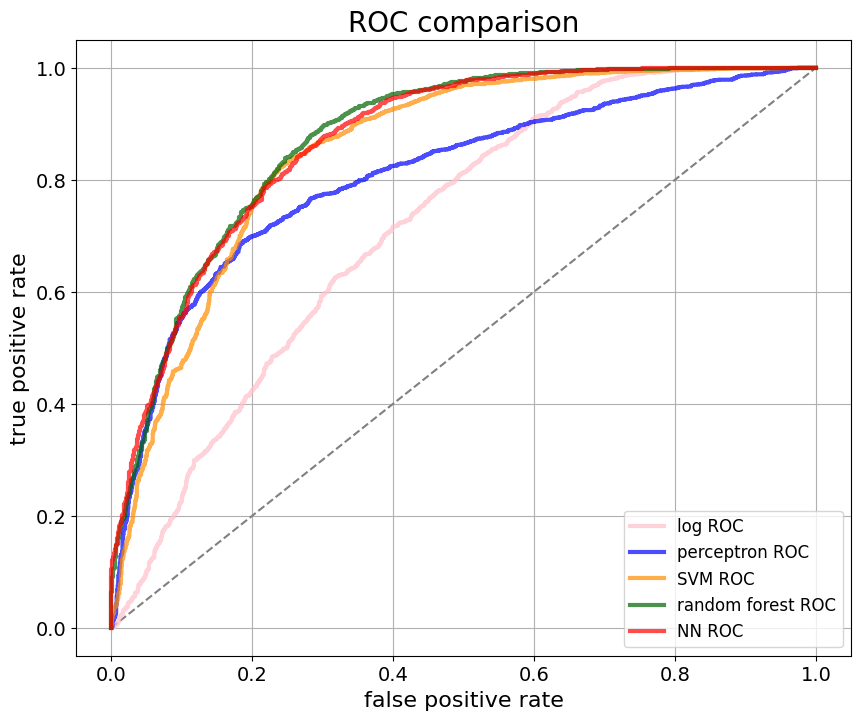

In [122]:
print('best NN Q value:',Q_NN.round(3))
print('best perceptron Q value:',Q_perceptron.round(3))
print('best SVM Q value:',Q_SVM.round(3))
print('best random forest Q value:',Q_rforest.round(3))
print('best log_reg Q value:',Q_log.round(3))

line_width = 3
transparency = 0.7
plt.figure(figsize=(10,8))
plt.grid()
plt.title('ROC comparison',fontsize=20)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr_log,tpr_log,label='log ROC',lw=line_width,alpha=transparency,c='pink')
plt.plot(fpr_perceptron,tpr_perceptron,label='perceptron ROC',lw=line_width,alpha=transparency,c='blue')
plt.plot(fpr_SVM,tpr_SVM,label='SVM ROC',lw=line_width,alpha=transparency,c='darkorange')
plt.plot(fpr_rforest,tpr_rforest,label='random forest ROC',lw=line_width,alpha=transparency,c='darkgreen')
plt.plot(fpr_NN,tpr_NN,c='red',label='NN ROC',lw=line_width,alpha=transparency)
plt.xlabel('false positive rate',fontsize=16)
plt.ylabel('true positive rate',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=4,fontsize=12)
plt.show()

From the ML analysis we can conclude that the Random Forest with 180 trees and maximum depth 16 is the best classification algorithm among the ones considered. In fact, despite  obtaining the same performace for the partial area under the ROC curve as the FFNN, the Random Forest returns a better test set Q value.       

In [125]:
import dill
dill.dump_session('save_lcpa.db')

# Part 6: cut on Alpha parameter
In this section we perform a cut on the Alpha feature, which we found to be the most informative to discriminate between signal and backgrund in the previous analysis. We impose a threshold such that events with a smaller Alpha will be classified as gammas, the remaining as background. We want to study the performance of this parameter. First we determine the overall best value for the Alpha cut, i.e., the cut that minimizes the FPR. However, since in this way we would discard almost all events as background, we consider also the value that allows to limit the FPR to less than 10%, which we found to be around 10°. With this cut we would correctly identify as signals around half of the total number of true gammas.


In [ ]:
X_train['fAlpha'] = train_alpha
X_test['fAlpha'] = test_alpha
print(X_train.columns[:])
print(X_train.shape[:])

Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fDist', 'fAlpha'],
      dtype='object')
(15216, 10)


total gammas: 2483 , tot hadrons: 1320 , tot test points: 3803
Best cut value is Alpha = 0.111 , with rate: 0.9714
#TP: 34   #FP: 1
Rate of saved gammas: 0.0137
 
Given threshold rate = 0.9, best cut is: 9.814 with rate 0.9001
#TP: 1217 #FP: 135 rate of saved gammas: 0.4901


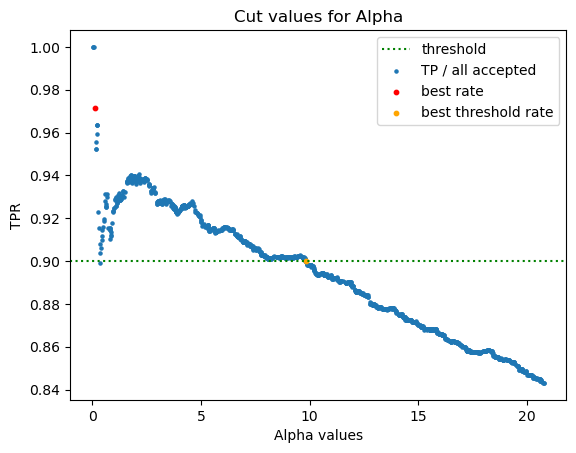

In [ ]:
tot_hadrons = len(Y_test[Y_test == -1])
tot_gammas = len(Y_test[Y_test == 1])
tot_hadrons_train = len(Y_train[Y_train == -1])
sel_label = 9
# sel label = Alpha == 9

cut_values = []
rates = []
absolute_tp = []
absolute_fp = []

# setting minimum threshold as 0.90 (editable)
thresh = 0.90


for i in range(1,tot_hadrons):
    cut_value = find_max_cut_value(X_train,Y_train,sel_label,i)

    # to check how the cut value behaves we get the results on test set
    tp, fp = find_tp_fp(X_test,Y_test,sel_label,cut_value)
    if (tp+fp == 0):
        tp = 1
    #print(cut_value,'  ',tp,'  ',fp,'  ',tp/(tp+fp))
    cut_values.append(cut_value)
    rates.append(tp/(tp+fp))
    absolute_tp.append(tp)
    absolute_fp.append(fp)

    if (tp/(tp+fp) > thresh):
        best_cut_thresh = cut_value
        rate_thresh = tp/(tp+fp)
        tp_thresh = tp
        fp_thresh = fp

rates = np.array(rates)
mask = np.where(rates < 1,rates,0)
index = np.argmax(mask)
best_rate = rates[index]
best_cut = cut_values[index]
best_tp = absolute_tp[index]
best_fp = absolute_fp[index]

print('total gammas:',tot_gammas,', tot hadrons:',tot_hadrons,', tot test points:',tot_gammas+tot_hadrons)
print('Best cut value is Alpha =',round(best_cut,4),', with rate:',round(best_rate,4))
print('#TP:',best_tp,'  #FP:',best_fp)
print('Rate of saved gammas:',round(best_tp / tot_gammas,4))
print(' ')
print('Given threshold rate = 0.9, best cut is:',round(best_cut_thresh,4),'with rate',round(rate_thresh,4))
print('#TP:',tp_thresh,'#FP:',fp_thresh,'rate of saved gammas:',round(tp_thresh / tot_gammas,4))

plt.axhline(y=0.9, color='g', linestyle=':',label='threshold')
plt.scatter(cut_values,rates, s= 5,label='TP / all accepted')
plt.scatter(best_cut,best_rate,c='red',s=10,label='best rate')
plt.scatter(best_cut_thresh,rate_thresh,c='orange',s=10,label='best threshold rate')
plt.legend()
plt.title('Cut values for Alpha')
plt.xlabel('Alpha values')
plt.ylabel('TPR')
plt.show();



# Part 7: Grid search for best gammaness and Alpha cut

We now apply the best model found in the previous part, i.e: the Random Forest, to look for the combination of parameters *gammaness* and *alpha cut* that maximizes the quality factor *Q*.

What we do is label as background (hadrons) all samples with Alpha greater than the *alpha cut* value considered; then we apply the best Random Forest classification to the remaining samples, labelling as gammas only the samples with a predicted probability of belonging to class +1 greater than *gammaness*. Finally, we determine the TPR and FPR to calculate the correspondent Q value.    
To avoid choosing the best combination of *alpha cut* and *gammaness* solely on the performance on a specific test set, we run the same algorithm on 10 different test sets and choose as best case the one that returns the highest average Q value over the iterations.

In [ ]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

file_name="magic04.data"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']


In [ ]:
data_rescaled = data
original_alpha = data['fAlpha'].copy()

for i in data.drop(columns=['category']).columns:
    h = data[i]
    avg = np.mean(h.astype(float))
    std = np.std(h)
    h = h - avg
    h = h / std
    data_rescaled[i]= h

print('avg length:',np.average(data_rescaled['fLength']))
print('dev_std length:',np.std(data_rescaled['fLength']))
data_rescaled['fAlpha'] = original_alpha
data_rescaled['category'] = data['category']
data_rescaled['category'] = data_rescaled['category'].replace({'g':1,'h':-1})


avg length: 3.5865241407523854e-17
dev_std length: 0.9999999999999971


In [ ]:
N=10
test_predictions=[]
gammaness= np.arange(0.8,0.96,0.01)
alpha_cut= np.arange(2,15,1)

for i in range(1,N+1):
    print('Iteration:',i,'\n')

    train_set, test_set = split_train_test_set( data_rescaled, 5)
    X_train, Y_train = split_X_Y(train_set)
    X_test, Y_test = split_X_Y(test_set)

    best_forest.fit(X_train,Y_train)

    for alpha in alpha_cut:
        print('\n')
        for g in gammaness:

            test_data = [ X_test[ X_test['fAlpha']<alpha], Y_test[X_test['fAlpha']<alpha] ]
            discarded_data = X_test[X_test['fAlpha'] >= alpha]
            discarded_labels = Y_test[X_test['fAlpha'] >= alpha] # we directly classify these points as hadrons

            y_pred_prob = best_forest.predict_proba(test_data[0])[:, 1]
            y_pred_label = np.where(y_pred_prob > g, 1, -1)

            selected_gammas= np.sum(y_pred_label==1)
            selected_hadrons= np.sum(y_pred_label==-1) + ( X_test.shape[0]-len(test_data[0])) # samples in alpha cut classified as hadron by the model + all samples previously discarded

            total_gammas = np.sum(Y_test==1) # over all the test set (before alpha cut)
            total_hadrons = np.sum(Y_test==-1)

            true_positives = np.sum( (y_pred_label==1) & (test_data[1]==1) )
            false_positives = np.sum( (y_pred_label==1) & (test_data[1]==-1) )
            true_negatives= np.sum((y_pred_label == -1) & (test_data[1] == -1)) + np.sum((discarded_labels == -1))
            false_negatives= np.sum((y_pred_label == -1) & (test_data[1] == 1)) + np.sum((discarded_labels == 1))

            if false_positives != 0:
                epsilon_gamma = true_positives / total_gammas # TPR
                epsilon_hadron = false_positives / total_hadrons # FPR
                Q = epsilon_gamma/np.sqrt(epsilon_hadron)
            else:
                epsilon_hadron= 0
                epsilon_gamma = true_positives / total_gammas
                Q = 'inf'

            test_predictions.append({
            'iteration': i,
            'alpha_cut': alpha,
            'gamma': g,
            'test_data': test_data,
            'pred_probs': y_pred_prob,
            'pred label': y_pred_label,
            'selected gammas': selected_gammas,
            'selected hadrons': selected_hadrons,
            'total gammas': total_gammas,
            'total hadrons': total_hadrons,
            'true positives': true_positives,
            'false positives': false_positives,
            'true negatives': true_negatives,
            'false negatives': false_negatives,
            'Q': Q })

            if Q != 'inf':
                print(f"With alpha cut {alpha} and gammaness {g:.2f}, Q = {Q:.4f}")
            else:
                print(f"With alpha cut {alpha} and gammanesss {g:.2f}, Q = {Q}")
            print(f"True positives {true_positives}; False positives {false_positives}")


Iteration: 1 



With alpha cut 2 and gammaness 0.80, Q = 1.6165
True positives 323; False positives 9
With alpha cut 2 and gammaness 0.81, Q = 1.6115
True positives 322; False positives 9
With alpha cut 2 and gammaness 0.82, Q = 1.6827
True positives 317; False positives 8
With alpha cut 2 and gammaness 0.83, Q = 1.6720
True positives 315; False positives 8
With alpha cut 2 and gammaness 0.84, Q = 1.7705
True positives 312; False positives 7
With alpha cut 2 and gammaness 0.85, Q = 1.9123
True positives 312; False positives 6
With alpha cut 2 and gammaness 0.86, Q = 1.8694
True positives 305; False positives 6
With alpha cut 2 and gammaness 0.87, Q = 1.8572
True positives 303; False positives 6
With alpha cut 2 and gammaness 0.88, Q = 2.0008
True positives 298; False positives 5
With alpha cut 2 and gammaness 0.89, Q = 1.9673
True positives 293; False positives 5
With alpha cut 2 and gammaness 0.90, Q = 2.1394
True positives 285; False positives 4
With alpha cut 2 and gammaness 0.91, 

With alpha cut 7 and gammaness 0.95, Q = 2.6899
True positives 646; False positives 13


With alpha cut 8 and gammaness 0.80, Q = 2.3596
True positives 956; False positives 37
With alpha cut 8 and gammaness 0.81, Q = 2.3897
True positives 955; False positives 36
With alpha cut 8 and gammaness 0.82, Q = 2.4332
True positives 945; False positives 34
With alpha cut 8 and gammaness 0.83, Q = 2.4515
True positives 938; False positives 33
With alpha cut 8 and gammaness 0.84, Q = 2.5465
True positives 929; False positives 30
With alpha cut 8 and gammaness 0.85, Q = 2.5705
True positives 922; False positives 29
With alpha cut 8 and gammaness 0.86, Q = 2.5147
True positives 902; False positives 29
With alpha cut 8 and gammaness 0.87, Q = 2.6146
True positives 888; False positives 26
With alpha cut 8 and gammaness 0.88, Q = 2.7392
True positives 875; False positives 23
With alpha cut 8 and gammaness 0.89, Q = 2.8110
True positives 858; False positives 21
With alpha cut 8 and gammaness 0.90, Q = 

With alpha cut 13 and gammaness 0.93, Q = 3.0272
True positives 924; False positives 21
With alpha cut 13 and gammaness 0.94, Q = 2.9744
True positives 886; False positives 20
With alpha cut 13 and gammaness 0.95, Q = 2.9194
True positives 825; False positives 18


With alpha cut 14 and gammaness 0.80, Q = 2.5159
True positives 1254; False positives 56
With alpha cut 14 and gammaness 0.81, Q = 2.5326
True positives 1251; False positives 55
With alpha cut 14 and gammaness 0.82, Q = 2.5448
True positives 1234; False positives 53
With alpha cut 14 and gammaness 0.83, Q = 2.5463
True positives 1223; False positives 52
With alpha cut 14 and gammaness 0.84, Q = 2.5931
True positives 1209; False positives 49
With alpha cut 14 and gammaness 0.85, Q = 2.5874
True positives 1194; False positives 48
With alpha cut 14 and gammaness 0.86, Q = 2.5447
True positives 1162; False positives 47
With alpha cut 14 and gammaness 0.87, Q = 2.6847
True positives 1145; False positives 41
With alpha cut 14 and 

With alpha cut 6 and gammaness 0.91, Q = 2.4482
True positives 759; False positives 21
With alpha cut 6 and gammaness 0.92, Q = 2.5817
True positives 741; False positives 18
With alpha cut 6 and gammaness 0.93, Q = 2.9353
True positives 716; False positives 13
With alpha cut 6 and gammaness 0.94, Q = 3.1785
True positives 680; False positives 10
With alpha cut 6 and gammaness 0.95, Q = 3.2027
True positives 650; False positives 9


With alpha cut 7 and gammaness 0.80, Q = 2.4934
True positives 969; False positives 33
With alpha cut 7 and gammaness 0.81, Q = 2.4779
True positives 963; False positives 33
With alpha cut 7 and gammaness 0.82, Q = 2.5301
True positives 953; False positives 31
With alpha cut 7 and gammaness 0.83, Q = 2.5530
True positives 946; False positives 30
With alpha cut 7 and gammaness 0.84, Q = 2.5802
True positives 940; False positives 29
With alpha cut 7 and gammaness 0.85, Q = 2.6119
True positives 935; False positives 28
With alpha cut 7 and gammaness 0.86, Q = 2

With alpha cut 12 and gammaness 0.89, Q = 3.0951
True positives 1108; False positives 28
With alpha cut 12 and gammaness 0.90, Q = 3.1018
True positives 1070; False positives 26
With alpha cut 12 and gammaness 0.91, Q = 3.1289
True positives 1037; False positives 24
With alpha cut 12 and gammaness 0.92, Q = 3.3218
True positives 1005; False positives 20
With alpha cut 12 and gammaness 0.93, Q = 3.6334
True positives 952; False positives 15
With alpha cut 12 and gammaness 0.94, Q = 3.9888
True positives 895; False positives 11
With alpha cut 12 and gammaness 0.95, Q = 3.8984
True positives 834; False positives 10


With alpha cut 13 and gammaness 0.80, Q = 2.8902
True positives 1297; False positives 44
With alpha cut 13 and gammaness 0.81, Q = 2.8613
True positives 1284; False positives 44
With alpha cut 13 and gammaness 0.82, Q = 2.8921
True positives 1268; False positives 42
With alpha cut 13 and gammaness 0.83, Q = 2.9634
True positives 1252; False positives 39
With alpha cut 13 and 

With alpha cut 5 and gammaness 0.87, Q = 2.0870
True positives 681; False positives 24
With alpha cut 5 and gammaness 0.88, Q = 2.0975
True positives 670; False positives 23
With alpha cut 5 and gammaness 0.89, Q = 2.2224
True positives 662; False positives 20
With alpha cut 5 and gammaness 0.90, Q = 2.4472
True positives 652; False positives 16
With alpha cut 5 and gammaness 0.91, Q = 2.5042
True positives 646; False positives 15
With alpha cut 5 and gammaness 0.92, Q = 2.7174
True positives 627; False positives 12
With alpha cut 5 and gammaness 0.93, Q = 2.7613
True positives 610; False positives 11
With alpha cut 5 and gammaness 0.94, Q = 2.8011
True positives 590; False positives 10
With alpha cut 5 and gammaness 0.95, Q = 2.8726
True positives 574; False positives 9


With alpha cut 6 and gammaness 0.80, Q = 2.1498
True positives 810; False positives 32
With alpha cut 6 and gammaness 0.81, Q = 2.1815
True positives 809; False positives 31
With alpha cut 6 and gammaness 0.82, Q = 2

With alpha cut 11 and gammaness 0.85, Q = 2.3786
True positives 1109; False positives 49
With alpha cut 11 and gammaness 0.86, Q = 2.3783
True positives 1086; False positives 47
With alpha cut 11 and gammaness 0.87, Q = 2.4173
True positives 1068; False positives 44
With alpha cut 11 and gammaness 0.88, Q = 2.3994
True positives 1048; False positives 43
With alpha cut 11 and gammaness 0.89, Q = 2.5086
True positives 1030; False positives 38
With alpha cut 11 and gammaness 0.90, Q = 2.6806
True positives 1010; False positives 32
With alpha cut 11 and gammaness 0.91, Q = 2.7164
True positives 991; False positives 30
With alpha cut 11 and gammaness 0.92, Q = 2.9083
True positives 949; False positives 24
With alpha cut 11 and gammaness 0.93, Q = 2.8300
True positives 904; False positives 23
With alpha cut 11 and gammaness 0.94, Q = 2.7688
True positives 865; False positives 22
With alpha cut 11 and gammaness 0.95, Q = 2.7998
True positives 834; False positives 20


With alpha cut 12 and ga

With alpha cut 4 and gammaness 0.83, Q = 2.0612
True positives 605; False positives 19
With alpha cut 4 and gammaness 0.84, Q = 2.2239
True positives 599; False positives 16
With alpha cut 4 and gammaness 0.85, Q = 2.2091
True positives 595; False positives 16
With alpha cut 4 and gammaness 0.86, Q = 2.2623
True positives 590; False positives 15
With alpha cut 4 and gammaness 0.87, Q = 2.3100
True positives 582; False positives 14
With alpha cut 4 and gammaness 0.88, Q = 2.3519
True positives 571; False positives 13
With alpha cut 4 and gammaness 0.89, Q = 2.3066
True positives 560; False positives 13
With alpha cut 4 and gammaness 0.90, Q = 2.3665
True positives 552; False positives 12
With alpha cut 4 and gammaness 0.91, Q = 2.4135
True positives 539; False positives 11
With alpha cut 4 and gammaness 0.92, Q = 2.5939
True positives 524; False positives 9
With alpha cut 4 and gammaness 0.93, Q = 2.5395
True positives 513; False positives 9
With alpha cut 4 and gammaness 0.94, Q = 2.56

With alpha cut 10 and gammaness 0.83, Q = 2.7437
True positives 1093; False positives 35
With alpha cut 10 and gammaness 0.84, Q = 2.8379
True positives 1081; False positives 32
With alpha cut 10 and gammaness 0.85, Q = 2.8540
True positives 1070; False positives 31
With alpha cut 10 and gammaness 0.86, Q = 2.9412
True positives 1048; False positives 28
With alpha cut 10 and gammaness 0.87, Q = 2.9940
True positives 1028; False positives 26
With alpha cut 10 and gammaness 0.88, Q = 3.0526
True positives 1007; False positives 24
With alpha cut 10 and gammaness 0.89, Q = 2.9708
True positives 980; False positives 24
With alpha cut 10 and gammaness 0.90, Q = 3.0301
True positives 957; False positives 22
With alpha cut 10 and gammaness 0.91, Q = 3.0398
True positives 938; False positives 21
With alpha cut 10 and gammaness 0.92, Q = 3.2885
True positives 913; False positives 17
With alpha cut 10 and gammaness 0.93, Q = 3.1444
True positives 873; False positives 17
With alpha cut 10 and gamm

With alpha cut 3 and gammaness 0.81, Q = 2.0198
True positives 475; False positives 13
With alpha cut 3 and gammaness 0.82, Q = 2.0113
True positives 473; False positives 13
With alpha cut 3 and gammaness 0.83, Q = 1.9943
True positives 469; False positives 13
With alpha cut 3 and gammaness 0.84, Q = 1.9900
True positives 468; False positives 13
With alpha cut 3 and gammaness 0.85, Q = 1.9858
True positives 467; False positives 13
With alpha cut 3 and gammaness 0.86, Q = 1.9518
True positives 459; False positives 13
With alpha cut 3 and gammaness 0.87, Q = 1.9220
True positives 452; False positives 13
With alpha cut 3 and gammaness 0.88, Q = 2.0525
True positives 444; False positives 11
With alpha cut 3 and gammaness 0.89, Q = 2.1041
True positives 434; False positives 10
With alpha cut 3 and gammaness 0.90, Q = 2.1822
True positives 427; False positives 9
With alpha cut 3 and gammaness 0.91, Q = 2.1617
True positives 423; False positives 9
With alpha cut 3 and gammaness 0.92, Q = 2.37

With alpha cut 9 and gammaness 0.80, Q = 2.6641
True positives 1028; False positives 35
With alpha cut 9 and gammaness 0.81, Q = 2.6537
True positives 1024; False positives 35
With alpha cut 9 and gammaness 0.82, Q = 2.7169
True positives 1018; False positives 33
With alpha cut 9 and gammaness 0.83, Q = 2.7211
True positives 1004; False positives 32
With alpha cut 9 and gammaness 0.84, Q = 2.7103
True positives 1000; False positives 32
With alpha cut 9 and gammaness 0.85, Q = 2.8214
True positives 991; False positives 29
With alpha cut 9 and gammaness 0.86, Q = 2.7758
True positives 975; False positives 29
With alpha cut 9 and gammaness 0.87, Q = 2.7189
True positives 955; False positives 29
With alpha cut 9 and gammaness 0.88, Q = 2.9355
True positives 938; False positives 24
With alpha cut 9 and gammaness 0.89, Q = 2.9876
True positives 914; False positives 22
With alpha cut 9 and gammaness 0.90, Q = 3.1339
True positives 891; False positives 19
With alpha cut 9 and gammaness 0.91, Q

With alpha cut 14 and gammaness 0.94, Q = 3.0169
True positives 880; False positives 20
With alpha cut 14 and gammaness 0.95, Q = 2.9704
True positives 822; False positives 18
Iteration: 6 



With alpha cut 2 and gammaness 0.80, Q = 2.1945
True positives 338; False positives 5
With alpha cut 2 and gammaness 0.81, Q = 2.1816
True positives 336; False positives 5
With alpha cut 2 and gammaness 0.82, Q = 2.1686
True positives 334; False positives 5
With alpha cut 2 and gammaness 0.83, Q = 2.1686
True positives 334; False positives 5
With alpha cut 2 and gammaness 0.84, Q = 2.4245
True positives 334; False positives 4
With alpha cut 2 and gammaness 0.85, Q = 2.4173
True positives 333; False positives 4
With alpha cut 2 and gammaness 0.86, Q = 2.7829
True positives 332; False positives 3
With alpha cut 2 and gammaness 0.87, Q = 3.3775
True positives 329; False positives 2
With alpha cut 2 and gammaness 0.88, Q = 3.3159
True positives 323; False positives 2
With alpha cut 2 and gammaness 0.

With alpha cut 7 and gammaness 0.93, Q = 3.0692
True positives 791; False positives 14
With alpha cut 7 and gammaness 0.94, Q = 3.1726
True positives 757; False positives 12
With alpha cut 7 and gammaness 0.95, Q = 3.0905
True positives 706; False positives 11


With alpha cut 8 and gammaness 0.80, Q = 2.3445
True positives 1034; False positives 41
With alpha cut 8 and gammaness 0.81, Q = 2.3875
True positives 1027; False positives 39
With alpha cut 8 and gammaness 0.82, Q = 2.3976
True positives 1018; False positives 38
With alpha cut 8 and gammaness 0.83, Q = 2.3811
True positives 1011; False positives 38
With alpha cut 8 and gammaness 0.84, Q = 2.4516
True positives 999; False positives 35
With alpha cut 8 and gammaness 0.85, Q = 2.5331
True positives 987; False positives 32
With alpha cut 8 and gammaness 0.86, Q = 2.6178
True positives 971; False positives 29
With alpha cut 8 and gammaness 0.87, Q = 2.7191
True positives 955; False positives 26
With alpha cut 8 and gammaness 0.88, 

With alpha cut 13 and gammaness 0.91, Q = 3.2965
True positives 1065; False positives 22
With alpha cut 13 and gammaness 0.92, Q = 3.2663
True positives 1031; False positives 21
With alpha cut 13 and gammaness 0.93, Q = 3.2941
True positives 989; False positives 19
With alpha cut 13 and gammaness 0.94, Q = 3.3900
True positives 934; False positives 16
With alpha cut 13 and gammaness 0.95, Q = 3.2350
True positives 863; False positives 15


With alpha cut 14 and gammaness 0.80, Q = 2.4117
True positives 1308; False positives 62
With alpha cut 14 and gammaness 0.81, Q = 2.4477
True positives 1295; False positives 59
With alpha cut 14 and gammaness 0.82, Q = 2.4420
True positives 1281; False positives 58
With alpha cut 14 and gammaness 0.83, Q = 2.4639
True positives 1270; False positives 56
With alpha cut 14 and gammaness 0.84, Q = 2.4928
True positives 1250; False positives 53
With alpha cut 14 and gammaness 0.85, Q = 2.5511
True positives 1230; False positives 49
With alpha cut 14 and 

With alpha cut 6 and gammaness 0.89, Q = 2.5360
True positives 721; False positives 19
With alpha cut 6 and gammaness 0.90, Q = 2.8146
True positives 711; False positives 15
With alpha cut 6 and gammaness 0.91, Q = 2.7512
True positives 695; False positives 15
With alpha cut 6 and gammaness 0.92, Q = 2.6720
True positives 675; False positives 15
With alpha cut 6 and gammaness 0.93, Q = 2.6757
True positives 653; False positives 14
With alpha cut 6 and gammaness 0.94, Q = 2.8938
True positives 626; False positives 11
With alpha cut 6 and gammaness 0.95, Q = 2.8508
True positives 588; False positives 10


With alpha cut 7 and gammaness 0.80, Q = 2.2458
True positives 891; False positives 37
With alpha cut 7 and gammaness 0.81, Q = 2.2640
True positives 886; False positives 36
With alpha cut 7 and gammaness 0.82, Q = 2.3191
True positives 882; False positives 34
With alpha cut 7 and gammaness 0.83, Q = 2.3219
True positives 870; False positives 33
With alpha cut 7 and gammaness 0.84, Q = 

With alpha cut 12 and gammaness 0.87, Q = 2.5072
True positives 1097; False positives 45
With alpha cut 12 and gammaness 0.88, Q = 2.5817
True positives 1065; False positives 40
With alpha cut 12 and gammaness 0.89, Q = 2.5816
True positives 1038; False positives 38
With alpha cut 12 and gammaness 0.90, Q = 2.7729
True positives 1007; False positives 31
With alpha cut 12 and gammaness 0.91, Q = 2.7516
True positives 983; False positives 30
With alpha cut 12 and gammaness 0.92, Q = 2.7351
True positives 944; False positives 28
With alpha cut 12 and gammaness 0.93, Q = 2.8197
True positives 901; False positives 24
With alpha cut 12 and gammaness 0.94, Q = 2.9827
True positives 848; False positives 19
With alpha cut 12 and gammaness 0.95, Q = 2.9190
True positives 785; False positives 17


With alpha cut 13 and gammaness 0.80, Q = 2.5768
True positives 1280; False positives 58
With alpha cut 13 and gammaness 0.81, Q = 2.5709
True positives 1266; False positives 57
With alpha cut 13 and ga

With alpha cut 5 and gammaness 0.85, Q = 1.8209
True positives 700; False positives 30
With alpha cut 5 and gammaness 0.86, Q = 1.8308
True positives 692; False positives 29
With alpha cut 5 and gammaness 0.87, Q = 1.8149
True positives 686; False positives 29
With alpha cut 5 and gammaness 0.88, Q = 1.8861
True positives 675; False positives 26
With alpha cut 5 and gammaness 0.89, Q = 1.9369
True positives 666; False positives 24
With alpha cut 5 and gammaness 0.90, Q = 2.0271
True positives 652; False positives 21
With alpha cut 5 and gammaness 0.91, Q = 2.0421
True positives 641; False positives 20
With alpha cut 5 and gammaness 0.92, Q = 2.2992
True positives 625; False positives 15
With alpha cut 5 and gammaness 0.93, Q = 2.3228
True positives 610; False positives 14
With alpha cut 5 and gammaness 0.94, Q = 2.7498
True positives 579; False positives 9
With alpha cut 5 and gammaness 0.95, Q = 2.7604
True positives 548; False positives 8


With alpha cut 6 and gammaness 0.80, Q = 1.

With alpha cut 11 and gammaness 0.83, Q = 2.2355
True positives 1153; False positives 54
With alpha cut 11 and gammaness 0.84, Q = 2.2484
True positives 1138; False positives 52
With alpha cut 11 and gammaness 0.85, Q = 2.2287
True positives 1128; False positives 52
With alpha cut 11 and gammaness 0.86, Q = 2.2446
True positives 1114; False positives 50
With alpha cut 11 and gammaness 0.87, Q = 2.2389
True positives 1100; False positives 49
With alpha cut 11 and gammaness 0.88, Q = 2.2853
True positives 1076; False positives 45
With alpha cut 11 and gammaness 0.89, Q = 2.3932
True positives 1049; False positives 39
With alpha cut 11 and gammaness 0.90, Q = 2.5422
True positives 1025; False positives 33
With alpha cut 11 and gammaness 0.91, Q = 2.5512
True positives 997; False positives 31
With alpha cut 11 and gammaness 0.92, Q = 2.9161
True positives 960; False positives 22
With alpha cut 11 and gammaness 0.93, Q = 2.8945
True positives 931; False positives 21
With alpha cut 11 and ga

With alpha cut 4 and gammaness 0.81, Q = 1.9606
True positives 620; False positives 23
With alpha cut 4 and gammaness 0.82, Q = 1.9448
True positives 615; False positives 23
With alpha cut 4 and gammaness 0.83, Q = 2.0221
True positives 611; False positives 21
With alpha cut 4 and gammaness 0.84, Q = 2.0022
True positives 605; False positives 21
With alpha cut 4 and gammaness 0.85, Q = 1.9956
True positives 603; False positives 21
With alpha cut 4 and gammaness 0.86, Q = 2.0737
True positives 596; False positives 19
With alpha cut 4 and gammaness 0.87, Q = 2.2370
True positives 590; False positives 16
With alpha cut 4 and gammaness 0.88, Q = 2.2218
True positives 586; False positives 16
With alpha cut 4 and gammaness 0.89, Q = 2.3468
True positives 579; False positives 14
With alpha cut 4 and gammaness 0.90, Q = 2.3429
True positives 557; False positives 13
With alpha cut 4 and gammaness 0.91, Q = 2.3092
True positives 549; False positives 13
With alpha cut 4 and gammaness 0.92, Q = 2.

With alpha cut 9 and gammaness 0.95, Q = 2.4994
True positives 773; False positives 22


With alpha cut 10 and gammaness 0.80, Q = 2.2195
True positives 1143; False positives 61
With alpha cut 10 and gammaness 0.81, Q = 2.2860
True positives 1138; False positives 57
With alpha cut 10 and gammaness 0.82, Q = 2.2860
True positives 1128; False positives 56
With alpha cut 10 and gammaness 0.83, Q = 2.3290
True positives 1118; False positives 53
With alpha cut 10 and gammaness 0.84, Q = 2.3240
True positives 1105; False positives 52
With alpha cut 10 and gammaness 0.85, Q = 2.3275
True positives 1096; False positives 51
With alpha cut 10 and gammaness 0.86, Q = 2.3685
True positives 1082; False positives 48
With alpha cut 10 and gammaness 0.87, Q = 2.4441
True positives 1069; False positives 44
With alpha cut 10 and gammaness 0.88, Q = 2.4377
True positives 1054; False positives 43
With alpha cut 10 and gammaness 0.89, Q = 2.4819
True positives 1035; False positives 40
With alpha cut 10 and

With alpha cut 2 and gammaness 0.93, Q = 1.7286
True positives 284; False positives 6
With alpha cut 2 and gammaness 0.94, Q = 1.8402
True positives 276; False positives 5
With alpha cut 2 and gammaness 0.95, Q = 1.9605
True positives 263; False positives 4


With alpha cut 3 and gammaness 0.80, Q = 1.6168
True positives 485; False positives 20
With alpha cut 3 and gammaness 0.81, Q = 1.6035
True positives 481; False positives 20
With alpha cut 3 and gammaness 0.82, Q = 1.5935
True positives 478; False positives 20
With alpha cut 3 and gammaness 0.83, Q = 1.5802
True positives 474; False positives 20
With alpha cut 3 and gammaness 0.84, Q = 1.6551
True positives 471; False positives 18
With alpha cut 3 and gammaness 0.85, Q = 1.6995
True positives 470; False positives 17
With alpha cut 3 and gammaness 0.86, Q = 1.8488
True positives 464; False positives 14
With alpha cut 3 and gammaness 0.87, Q = 1.8249
True positives 458; False positives 14
With alpha cut 3 and gammaness 0.88, Q = 1.7

With alpha cut 8 and gammaness 0.93, Q = 2.3183
True positives 808; False positives 27
With alpha cut 8 and gammaness 0.94, Q = 2.3555
True positives 774; False positives 24
With alpha cut 8 and gammaness 0.95, Q = 2.3652
True positives 727; False positives 21


With alpha cut 9 and gammaness 0.80, Q = 2.2644
True positives 1074; False positives 50
With alpha cut 9 and gammaness 0.81, Q = 2.2455
True positives 1065; False positives 50
With alpha cut 9 and gammaness 0.82, Q = 2.2181
True positives 1052; False positives 50
With alpha cut 9 and gammaness 0.83, Q = 2.1991
True positives 1043; False positives 50
With alpha cut 9 and gammaness 0.84, Q = 2.2251
True positives 1034; False positives 48
With alpha cut 9 and gammaness 0.85, Q = 2.2312
True positives 1026; False positives 47
With alpha cut 9 and gammaness 0.86, Q = 2.2790
True positives 1014; False positives 44
With alpha cut 9 and gammaness 0.87, Q = 2.2498
True positives 1001; False positives 44
With alpha cut 9 and gammaness 0.

With alpha cut 14 and gammaness 0.91, Q = 2.3197
True positives 1078; False positives 48
With alpha cut 14 and gammaness 0.92, Q = 2.3262
True positives 1035; False positives 44
With alpha cut 14 and gammaness 0.93, Q = 2.3847
True positives 986; False positives 38
With alpha cut 14 and gammaness 0.94, Q = 2.4032
True positives 926; False positives 33
With alpha cut 14 and gammaness 0.95, Q = 2.3837
True positives 861; False positives 29


To handle the very few cases that return 0 false positives and thus an "infinite" Q value, we decide to consider the median of the Q values across the different iterations instead of the average. To estimate the standard deviation of the values found we ignore these cases.     

In [ ]:
test_predictions_df = pd.DataFrame(test_predictions)
test_predictions_df['Q'] = test_predictions_df['Q'].replace('inf', 1e20) # assign very high value to Q to find median
test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median_Q = 'median',
    std= lambda x: np.std(x[x != 1e20])).reset_index()

,alpha_cut,gamma,median_Q,std
0,2,0.80,1.648986,0.232957
1,2,0.81,1.646484,0.231270
2,2,0.82,1.677085,0.242190
3,2,0.83,1.794507,0.224681
4,2,0.84,1.803708,0.405646
...,...,...,...,...
203,14,0.91,2.826253,0.281013
204,14,0.92,2.923633,0.321635
205,14,0.93,2.923225,0.362002
206,14,0.94,2.919246,0.433370


In [ ]:
grouped_pred = test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median= 'median',
    std= lambda x: np.std(x[x != 1e20]) ).reset_index()

max_mean_row = grouped_pred.loc[grouped_pred['median'].idxmax()]

max_mean = max_mean_row['median']
std_dev = max_mean_row['std']

print(f"The best average Q value found is {max_mean:.2f} ± {std_dev/(N)**0.5:.2f}")
print(f"The best Alpha cut found is {max_mean_row['alpha_cut']:.0f}° ")
print(f"The best gammaness found is {max_mean_row['gamma']:.2f}")

The best average Q value found is 3.07 ± 0.12
The best Alpha cut found is 10° 
The best gammaness found is 0.94


In [ ]:
selected = test_predictions_df[
    (test_predictions_df['gamma'] == max_mean_row['gamma']) &
    (test_predictions_df['alpha_cut'] == max_mean_row['alpha_cut'])]

selected_gammas = selected['selected gammas']/selected['total gammas']
avg_selected_gammas= selected_gammas.mean()
std_selected_gammas= selected_gammas.std()
print(f"With these best parameters, the average fraction of selected gammas is ({avg_selected_gammas*100:.2f} ± {std_selected_gammas*100/(N)**0.5:.2f})%")

With these best parameters, the average fraction of selected gammas is (34.83 ± 0.32)%


This means that, applying this technique on the given dataset with $N_{\gamma} = 12332$ true gamma events, we would identify $n_{\gamma} = (4295 ± 39)$ events as gamma, disregarding the remaining as backgrund. In particular we have the following average performance for the algorithm in terms of TPR, FPR, TNR, FNR:

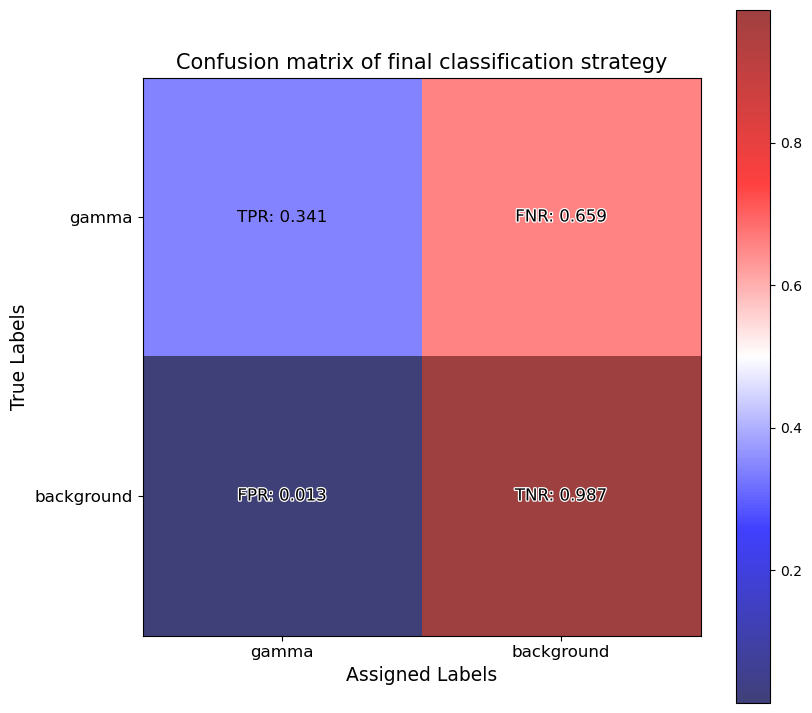

In [ ]:

tpr = selected['true positives']/selected['total gammas']
tpr_avg = tpr.mean()

fpr = selected['false positives']/selected['total hadrons']
fpr_avg = fpr.mean()

tnr = selected['true negatives']/selected['total hadrons']
tnr_avg= tnr.mean()

fnr = selected['false negatives']/selected['total gammas']
fnr_avg= fnr.mean()

confusion_matrix = np.array([[tpr_avg, fnr_avg], [fpr_avg, tnr_avg]])

fig, ax = plt.subplots(figsize=(9, 9))
cax = ax.matshow(confusion_matrix, cmap='seismic',alpha=0.75)

ax.set_xticks([0, 1])
ax.set_xticklabels(['gamma', 'background'],fontsize=12)
ax.xaxis.set_ticks_position('bottom')
ax.set_yticks([0, 1])
ax.set_yticklabels(['gamma', 'background'],fontsize=12)

path_effects_white = [path_effects.withStroke(linewidth=1.8, foreground='white')]

# Adding text with white contour
text_params = {'ha': 'center', 'va': 'center', 'color': 'black', 'fontsize': 12, 'path_effects': path_effects_white}


ax.text(0, 0, f'TPR: {tpr_avg:.3f}', ha='center', va='center', color='black',fontsize=12)
ax.text(1, 0, f'FNR: {fnr_avg:.3f}', **text_params)
ax.text(0, 1, f'FPR: {fpr_avg:.3f}', **text_params)
ax.text(1, 1, f'TNR: {tnr_avg:.3f}', **text_params)

fig.colorbar(cax)

ax.set_title('Confusion matrix of final classification strategy',fontsize=15)
ax.set_xlabel('Assigned Labels',fontsize=13.5)
ax.set_ylabel('True Labels',fontsize=13.5)

plt.show()

# Part 8: Calculation of the observation time
## Part 8.1: Spectrum by HEGRA

To calculate the observation time we use the Crab Nebula spectrum measured by HEGRA. Using the telescope's collection area ($A = 10^9 \, \text{cm}^2$), we can determine the event rate by integrating the flux over the energy range from **50 GeV to 50 TeV**:

$$
R = A \cdot J_{\gamma} =  A \int_{0.05 \, TeV}^{50 \, TeV} \frac{dJ_{\gamma}}{dE} dE
$$

This integration provides the event rate in photons per second. Given the total number of gamma events $n_\gamma$, we can then calculate the observation time by dividing the number of gamma events by the event rate:

$$
\Delta t = \frac{n_{\gamma}}{R}
$$

In [ ]:
# Constants
A = 10**9 * 1e-4
E0 = 1.0
Emin = 0.05
Emax = 50
n_gamma, sigma_n_gamma =  4295, 39


alpha1, alpha1_err = 2.59, 0.03
c1, c1_err = 2.79e-7, 0.02e-7


c2, c2_err = 2.67e-7, 0.01e-7
alpha2, alpha2_err = 2.47, 0.1
beta, beta_err = -0.11, 0.1

### First integral: power law fit
According to the study by Aharonian et al. (2000), the differential flux of gamma rays is best fitted by a pure power law and a log-parabola functions.
<br> <br> The first integral is the power law fit:
$$
\frac{dJ_{\gamma}}{dE} = (2.79 \pm 0.02) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.59 \pm 0.03)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
This integral can be calculated analytically:
$$
J_\gamma = \frac{E_0^{\alpha_1} \cdot c_1}{-\alpha_1 + 1} \cdot \left( E_{\text{max}}^{-\alpha_1 + 1} - E_{\text{min}}^{-\alpha_1 + 1} \right)
$$
with $ c_1 = (2.79 \pm 0.02) \times 10^{-7} \, \text{TeV}^{-1} \, \text{m}^{-2} \, \text{s}^{-1}, \, E_0 = 1 \, \text{TeV}, \, \alpha_1 = 2.59 \pm 0.03, \, E_{\text{min}} = 0.05 \, \text{TeV}, \, E_{\text{max}} = 50 \, \text{TeV} $.
<br> <br> The error on $ \text{t} $ is propagated from the uncertainties in the parameters $ c_1 $ and $\alpha_1$ given by Aharonian's paper and $ n_\gamma $, using their respective derivatives.

In [ ]:
def dJ_H(E, c1, alpha1):
    return c1 * np.power((E / E0), - alpha1)

def uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err):
    c1_sym, alpha1_sym, Emin_sym, Emax_sym, E0_sym, A_sym = sp.symbols('c1 alpha1 Emin Emax E0 A')

    R = (A_sym * c1_sym * (E0_sym**alpha1_sym) / (-alpha1_sym + 1)) * (Emax_sym**(-alpha1_sym + 1) - Emin_sym**(-alpha1_sym + 1))

    dR_dc1 = sp.diff(R, c1_sym)
    dR_dalpha1 = sp.diff(R, alpha1_sym)

    dR_dc1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dc1, 'numpy')
    dR_dalpha1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dalpha1, 'numpy')

    dR_dc1_val = dR_dc1_func(A, E0, Emin, Emax, c1, alpha1)
    dR_dalpha1_val = dR_dalpha1_func(A, E0, Emin, Emax, c1, alpha1)
    R_val = (A * c1 * (E0**alpha1) / (-alpha1 + 1)) * (Emax**(-alpha1 + 1) - Emin**(-alpha1 + 1))

    sigma_R = np.sqrt((dR_dc1_val * c1_err) ** 2 + (dR_dalpha1_val * alpha1_err) ** 2)

    return R_val, sigma_R

R_val, sigma_R = uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err)
t1_H = (n_gamma / R_val) / 60
sigma_t1_H = t1_H * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R_val)**2))

print("HEGRA with Power law")
print(f"t = {t1_H:.1f} ± {sigma_t1_H:.1f} minutes")

HEGRA with Power law
t = 34.8 ± 2.5 minutes


### Second integral: log-parabola fit
The second integral is the log-parabola fit given by:
$$
\frac{dJ_{\gamma}}{dE} = (2.67 \pm 0.01) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.47 \pm 0.1) -(0.11 \pm 0.1) \, \log(E/1 \, \text{TeV})} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
Because of the logarithmic correction, it's impossible to integrate it analytically in a straightforward way. Hence, to calculate this integral, we use two numerical integration methods: Simpson's Rule and Monte Carlo.
<br> Also in this case the error on $ \text{t} $ is calculated using propagation.

#### Simpson's Rule

In [ ]:
n = int(10e6)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_H(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E))

J_gamma_values = dJ_Simp_H(E_values, c2, alpha2, beta)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_dc2_values = dJ_Simp_H(E_values, c2, alpha2, beta)  / c2
    dJ_dc2 = simpson(dJ_dc2_values, E_values)

    dJ_dalpha2_values = - dJ_Simp_H(E_values, c2, alpha2, beta) * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2_values, E_values)

    dJ_dbeta_values = -dJ_Simp_H(E_values, c2, alpha2, beta) * np.log(E_values/E0) * np.log(E_values)
    dJ_dbeta = simpson(dJ_dbeta_values, E_values)

    return dJ_dc2, dJ_dalpha2, dJ_dbeta

dJ_dc2, dJ_dalpha2, dJ_dbeta = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_dc2 * c2_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta * beta_err) ** 2
)

sigma_R = R * (sigma_J / J_gamma)

t2_Simp_H = (n_gamma / R) /60
sigma_t2_Simp_H = t2_Simp_H * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("HEGRA with Log-parabola fit using Simpson's Rule")
print(f"t = {t2_Simp_H:.1f} ± {sigma_t2_Simp_H:.1f} minutes")

HEGRA with Log-parabola fit using Simpson's Rule
t = 88.1 ± 49.0 minutes


#### Monte Carlo

In [ ]:
random_seed = 42

def dJ_MC_H(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E/E0))

def calculate_integral(c2, alpha2, beta, seed):
    if seed is not None:
        np.random.seed(seed)

    n = int(10e5)
    E_values = np.linspace(Emin, Emax, n+1)
    y_max = np.max(dJ_MC_H(E_values, c2, alpha2, beta))
    N = int(10e6)
    E_samples = np.random.uniform(Emin, Emax, N)
    y_samples = np.random.uniform(0, y_max, N)
    f_values = dJ_MC_H(E_samples, c2, alpha2, beta)
    count = np.sum(y_samples < f_values)
    I = (Emax - Emin) * y_max * (count / N)

    # Monte Carlo statistical error
    p = count / N
    sigma_I_MC = I * np.sqrt((1 - p) / (p * N))

    return I, sigma_I_MC

I_nominal, sigma_I_MC = calculate_integral(c2, alpha2, beta, seed=random_seed)

# central differences for better accuracy
I_plus_c2, _ = calculate_integral(c2 + c2_err/2, alpha2, beta, seed=random_seed)
I_minus_c2, _ = calculate_integral(c2 - c2_err/2, alpha2, beta, seed=random_seed)

I_plus_alpha2, _ = calculate_integral(c2, alpha2 + alpha2_err/2, beta, seed=random_seed)
I_minus_alpha2, _ = calculate_integral(c2, alpha2 - alpha2_err/2, beta, seed=random_seed)

I_plus_beta, _ = calculate_integral(c2, alpha2, beta + beta_err/2, seed=random_seed)
I_minus_beta, _ = calculate_integral(c2, alpha2, beta - beta_err/2, seed=random_seed)


dI_dc2 = (I_plus_c2 - I_minus_c2) / c2_err
dI_dalpha2 = (I_plus_alpha2 - I_minus_alpha2) / alpha2_err
dI_dbeta = (I_plus_beta - I_minus_beta) / beta_err

var_I_c2 = (dI_dc2 * c2_err)**2
var_I_alpha2 = (dI_dalpha2 * alpha2_err)**2
var_I_beta = (dI_dbeta * beta_err)**2
var_I_MC = sigma_I_MC**2

var_I_total = var_I_c2 + var_I_alpha2 + var_I_beta + var_I_MC
sigma_I_total = np.sqrt(var_I_total)

t2_MC_H = n_gamma / (A * I_nominal) / 60
sigma_t2_MC_H = t2_MC_H * np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_I_total / I_nominal)**2)

print("HEGRA with Log-parabola fit using Monte Carlo")
print(f"t = {t2_MC_H:.1f} ± {sigma_t2_MC_H:.1f} minutes")

HEGRA with Log-parabola fit using Monte Carlo
t = 88.2 ± 49.9 minutes


The final results of the observation time using the Crab Nebula spectrum measured by HEGRA are:
- power law fit:
<br>  $ \text{t} = 34.8 ± 2.5 \, \text{minutes} $
- log-parabola fit:
  1. Simspon's Rule:
<br>  $ \text{t} = 88.1 ± 49.0 \, \text{minutes} $
  2. Monte Carlo method:
<br> $ \text{t} = 88.2 ± 49.9 \, \text{minutes} $

The large error in the log-parabola fit is due to the fact that the parameters  $\alpha$ and $\beta$ have relatively large errors (around $\mathcal{O}(10^{-1})$), these uncertainties contribute significantly to the error in  $J_{\gamma}$, which then propagates on $\text{t}$.

## Part 8.2: Spectrum by MAGIC

We repeat the same procedure as before but now using the Crab Nebula spectrum measured by the MAGIC stereoscopic system.
<br> Also in this case there are two different functional forms that describes the energy spectrum: log-parabola and a power law with an exponential cut off. Both spectra are calculated using the Simpson's Rule and Monte Carlo method.

In [ ]:
#Constants
A = 10**9
E0 = 1.0
Emin = 0.05
Emax = 50
n_gamma, sigma_n_gamma = 4295, 39

f0, f0_err = 3.80e-11, 0.11e-11
alpha, alpha_err = 2.21, 0.02
Ec, Ec_err = 6.0, 0.6

f02, f02_err = 3.23e-11, 0.03e-11
alpha2, alpha2_err = 2.47, 0.01
beta2, beta2_err = -0.24, 0.01

### First integral: exponential cut off

The first integral is given by:
$$
\frac{dJ_{\gamma}}{dE} = f_0 \cdot \left( \frac{E}{E_0} \right)^{- \alpha} e^{-E/E_C} \, \text{ph} \, \text{cm}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with $ f_0 = (3.80 \pm 0.11) \times 10^{-11} \, \text{TeV}^{-1} \, \text{cm}^{-2} \, \text{s}^{-1}, \, \alpha = 2.21 \pm 0.02, \, E_C = 6.0 \pm 0.6 \, \text{TeV}, \, E_0 = 1 \, \text{TeV}$.

#### Simpson's Rule

In [ ]:
n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_M(E, f0, alpha, Ec):
    return f0 * (E / E0) ** (- alpha) * np.exp(- E / Ec)

J_gamma_values = dJ_Simp_M(E_values, f0, alpha, Ec)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_df0_values = dJ_Simp_M(E_values, f0, alpha, Ec) / f0
    dJ_df0 = simpson(dJ_df0_values, E_values)

    dJ_dalpha_values = - dJ_Simp_M(E_values, f0, alpha, Ec) * np.log(E_values / E0)
    dJ_dalpha = simpson(dJ_dalpha_values, E_values)

    dJ_dEc_values = -dJ_Simp_M(E_values, f0, alpha, Ec) * (E_values / (Ec**2))
    dJ_dEc = simpson(dJ_dEc_values, E_values)

    return dJ_df0, dJ_dalpha, dJ_dEc

dJ_df0, dJ_dalpha, dJ_dEc = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_df0 * f0_err) ** 2 +
    (dJ_dalpha * alpha_err) ** 2 +
    (dJ_dEc * Ec_err) ** 2
)

sigma_R = (R * sigma_J) / J_gamma

t1_Simp_M = (n_gamma / R)/60
sigma_t1_Simp_M = t1_Simp_M * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("MAGIC Power law with cut off using Simpson's Rule")
print(f"t = {t1_Simp_M:.1f} ± {sigma_t1_Simp_M:.1f} minutes")

MAGIC Power law with cut off using Simpson's Rule
t = 62.7 ± 3.4 minutes


#### Monte Carlo

In [ ]:
random_seed = 42

def dJ1_MC_M(E, f0, alpha, Ec):
    return f0 * (E / E0) ** (- alpha) * np.exp(- E / Ec)

def calculate_integral(f0, alpha, Ec, seed):
    if seed is not None:
        np.random.seed(seed)

    n = int(10e5)
    E_values = np.linspace(Emin, Emax, n+1)
    y_max = np.max(dJ1_MC_M(E_values, f0, alpha, Ec))
    N = int(10e6)
    E_samples = np.random.uniform(Emin, Emax, N)
    y_samples = np.random.uniform(0, y_max, N)
    f_values = dJ1_MC_M(E_samples, f0, alpha, Ec)
    count = np.sum(y_samples < f_values)
    I = (Emax - Emin) * y_max * (count / N)

    p = count / N
    sigma_I_MC = I * np.sqrt((1 - p) / (p * N))

    return I, sigma_I_MC

I_nominal, sigma_I_MC = calculate_integral(f0, alpha, Ec, seed=random_seed)

I_plus_f0, _ = calculate_integral(f0 + f0_err/2, alpha, Ec, seed=random_seed)
I_minus_f0, _ = calculate_integral(f0 - f0_err/2, alpha, Ec, seed=random_seed)

I_plus_alpha, _ = calculate_integral(f0, alpha + alpha_err/2, Ec, seed=random_seed)
I_minus_alpha, _ = calculate_integral(f0, alpha - alpha_err/2, Ec, seed=random_seed)

I_plus_Ec, _ = calculate_integral(f0, alpha, Ec + Ec_err/2, seed=random_seed)
I_minus_Ec, _ = calculate_integral(f0, alpha, Ec - Ec_err/2, seed=random_seed)

dI_df0 = (I_plus_f0 - I_minus_f0) / f0_err
dI_dalpha = (I_plus_alpha - I_minus_alpha) / alpha_err
dI_dEc = (I_plus_Ec - I_minus_Ec) / Ec_err

var_I_f0 = (dI_df0 * f0_err)**2
var_I_alpha = (dI_dalpha * alpha_err)**2
var_I_Ec = (dI_dEc * Ec_err)**2
var_I_MC = sigma_I_MC**2

var_I_total = var_I_f0 + var_I_alpha + var_I_Ec + var_I_MC
sigma_I_total = np.sqrt(var_I_total)

t1_MC_M = n_gamma / (A * I_nominal) / 60
sigma_t1_MC_M = t1_MC_M * np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_I_total / I_nominal)**2)

print('MAGIC Power law with cut off using Monte Carlo')
print(f"t = {t1_MC_M:.1f} ± {sigma_t1_MC_M:.1f} minutes")

MAGIC Power law with cut off using Monte Carlo
t = 62.7 ± 3.4 minutes


### Second integral (Log-parabola)

The second integral, instead, is given by:
$$
\frac{dJ_{\gamma}}{dE} = f_0 \cdot \left( \frac{E}{E_0} \right)^{- \alpha + \beta \, \log(E / E_0)} \, \text{ph} \, \text{cm}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with $ f_0 = (3.23 \pm 0.03) \times 10^{-11} \, \text{TeV}^{-1} \, \text{cm}^{-2} \, \text{s}^{-1}, \, \alpha = 2.47 \pm 0.01, \, \beta = -0.24 \pm 0.01, \, E_0 = 1 \, \text{TeV} $.

#### Simpson's Rule

In [ ]:
n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_M(E, f02, alpha2, beta2):
    return f02 * (E / E0) ** (- alpha2 + beta2 * np.log(E / E0))

J_gamma_values = dJ_Simp_M(E_values, f02, alpha2, beta2)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_df02_values = dJ_Simp_M(E_values, f02, alpha2, beta2) / f02
    dJ_df02 = simpson(dJ_df02_values, E_values)

    dJ_dalpha2_values = - dJ_Simp_M(E_values, f02, alpha2, beta2) * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2_values, E_values)

    dJ_dbeta2_values = -dJ_Simp_M(E_values, f02, alpha2, beta2) * (np.log(E_values / E0))**2
    dJ_dbeta2 = simpson(dJ_dbeta2_values, E_values)

    return dJ_df02, dJ_dalpha2, dJ_dbeta2

dJ_df02, dJ_dalpha2, dJ_dbeta2 = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_df02 * f02_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta2 * beta2_err) ** 2
)

sigma_R = (R * sigma_J) / J_gamma

t2_Simp_M = (n_gamma / R)/60
sigma_t2_Simp_M = t2_Simp_M * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("MAGIC with Log-parabola fit using Simpson's Rule")
print(f"t = {t2_Simp_M:.1f} ± {sigma_t2_Simp_M:.1f} minutes")

MAGIC with Log-parabola fit using Simpson's Rule
t = 133.9 ± 6.4 minutes


#### Monte Carlo

In [ ]:
random_seed = 42

def dJ2_MC_M(E, f02, alpha2, beta2):
    return f02 * (E / E0) ** (- alpha2 + beta2 * np.log(E / E0))

def calculate_integral(f02, alpha2, beta2, seed):
    if seed is not None:
        np.random.seed(seed)

    n = int(10e5)
    E_values = np.linspace(Emin, Emax, n+1)
    y_max = np.max(dJ2_MC_M(E_values, f02, alpha2, beta2))
    N = int(10e6)
    E_samples = np.random.uniform(Emin, Emax, N)
    y_samples = np.random.uniform(0, y_max, N)
    f_values = dJ2_MC_M(E_samples, f02, alpha2, beta2)
    count = np.sum(y_samples < f_values)
    I = (Emax - Emin) * y_max * (count / N)

    p = count / N
    sigma_I_MC = I * np.sqrt((1 - p) / (p * N))

    return I, sigma_I_MC

I_nominal, sigma_I_MC = calculate_integral(f02, alpha2, beta2, seed=random_seed)

I_plus_f02, _ = calculate_integral(f02 + f02_err/2, alpha2, beta2, seed=random_seed)
I_minus_f02, _ = calculate_integral(f02 - f02_err/2, alpha2, beta2, seed=random_seed)

I_plus_alpha2, _ = calculate_integral(f02, alpha2 + alpha2_err/2, beta2, seed=random_seed)
I_minus_alpha2, _ = calculate_integral(f02, alpha2 - alpha2_err/2, beta2, seed=random_seed)

I_plus_beta2, _ = calculate_integral(f02, alpha2, beta2 + beta2_err/2, seed=random_seed)
I_minus_beta2, _ = calculate_integral(f02, alpha2, beta2 - beta2_err/2, seed=random_seed)

dI_df02 = (I_plus_f02 - I_minus_f02) / f02_err
dI_dalpha2 = (I_plus_alpha2 - I_minus_alpha2) / alpha2_err
dI_dbeta2 = (I_plus_beta2 - I_minus_beta2) / beta2_err

var_I_f02 = (dI_df02 * f02_err)**2
var_I_alpha2 = (dI_dalpha2 * alpha2_err)**2
var_I_beta2 = (dI_dbeta2 * beta2_err)**2
var_I_MC = sigma_I_MC**2

var_I_total = var_I_f02 + var_I_alpha2 + var_I_beta2 + var_I_MC
sigma_I_total = np.sqrt(var_I_total)

t2_MC_M = n_gamma / (A * I_nominal) / 60
sigma_t2_MC_M = t2_MC_M * np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_I_total / I_nominal)**2)

print('MAGIC with Log-parabola fit using Monte Carlo')
print(f"t = {t2_MC_M:.1f} ± {sigma_t2_MC_M:.1f} minutes")

MAGIC with Log-parabola fit using Monte Carlo
t = 133.7 ± 6.8 minutes


The final results of the observation time using the Crab Nebula spectrum measured by MAGIC are:
- power law with cut off fit:
  1. Simspon's Rule:
<br>  $ \text{t} = 62.7 ± 3.4 \, \text{minutes} $
  2. Monte Carlo method:
<br>  $ \text{t} = 62.7 ± 3.4 \, \text{minutes} $
- log-parabola fit:
  1. Simspon's Rule:
<br> $ \text{t} = 133.9 ± 6.4 \, \text{minutes} $
  2. Monte Carlo method:
<br> $ \text{t} =  133.7 ± 6.8 \, \text{minutes} $

## Part 8.3: Plot of the Energy Spectrum
Finally we plot the energy spectra using the different functional form given by the two papers to see if there is consistency between the observation time estimates found and the energy spectra trends.<br> In the following plot we show the results obtained with Simpson's Rule.

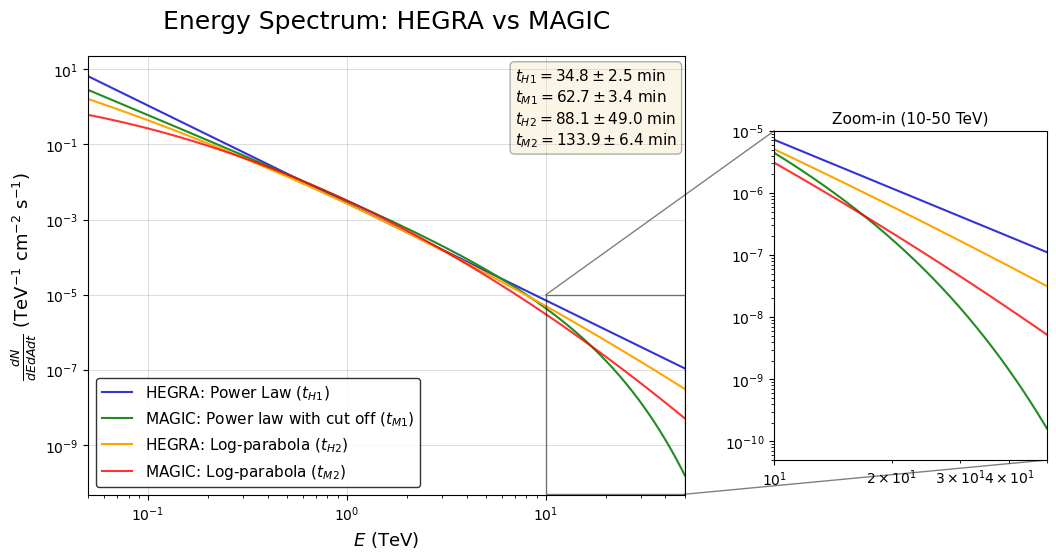

In [ ]:
E = np.linspace(Emin, Emax, 2**20+1)

fig, ax = plt.subplots(figsize=(7.7, 5.7))

ax.plot(E, 1e8 * dJ_H(E, (c1 * 1e-4), alpha1), color='mediumblue', alpha=0.8, label='HEGRA: Power Law ($t_{H1}$)')
ax.plot(E, 1e8 * dJ1_MC_M(E, f0, alpha, Ec), color='forestgreen', label='MAGIC: Power law with cut off ($t_{M1}$)')
ax.plot(E, 1e8 * dJ_MC_H(E, (c2 * 1e-4), alpha2, beta), color='orange', label='HEGRA: Log-parabola ($t_{H2}$)')
ax.plot(E, 1e8 * dJ2_MC_M(E, f02, alpha2, beta2), color='red', alpha=0.8, label='MAGIC: Log-parabola ($t_{M2}$)')
ax.semilogx()
ax.semilogy()
ax.set_xlim([Emin, Emax])
ax.set_xlabel(r'$E$ (TeV)', fontsize=13)
ax.set_ylabel(r'$\frac{dN}{dE dA dt}$ (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=13)
ax.set_title('Energy Spectrum: HEGRA vs MAGIC', fontsize=18, pad=20)
ax.legend(loc='lower left', fontsize=11, frameon=True, edgecolor='black')
ax.grid(True, linestyle='-', linewidth=0.6, alpha=0.5)

#Zoom-in
x1, x2, y1, y2 = 1e1, 5e1, 5e-11, 1e-5

axins = ax.inset_axes([1.15, 0.08, 0.457, 0.75])
axins.plot(E, 1e8 * dJ_H(E, (c1 * 1e-4), alpha1), color='mediumblue', alpha=0.8)
axins.plot(E, 1e8 * dJ_MC_H(E, (c2 * 1e-4), alpha2, beta), color='orange')
axins.plot(E, 1e8 * dJ1_MC_M(E, f0, alpha, Ec), color='forestgreen')
axins.plot(E, 1e8 * dJ2_MC_M(E, f02, alpha2, beta2), color='red', alpha=0.8)
axins.semilogx()
axins.semilogy()
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_title('Zoom-in (10-50 TeV)', fontsize=11)

ax.indicate_inset_zoom(axins, edgecolor="black")

#Results
textstr = (
    r'$t_{H1} = %.1f \pm %.1f$ min' % (t1_H, sigma_t1_H) + '\n' +
    r'$t_{M1} = %.1f \pm %.1f$ min' % (t1_Simp_M, sigma_t1_Simp_M) + '\n' +
    r'$t_{H2} = %.1f \pm %.1f$ min' % (t2_Simp_H, sigma_t2_Simp_H) + '\n' +
    r'$t_{M2} = %.1f \pm %.1f$ min' % (t2_Simp_M, sigma_t2_Simp_M)
)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
ax.text(0.715, 0.977, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.show()

We can see that the log-parabola fit of MAGIC indicate a spectral curvature that HEGRA could not detect due to lower sensitivity.
<br> For both spectral models (power law and log-parabola), MAGIC requires longer observation times than HEGRA ($ t_{M1} > t_{H1} $, $t_{M2} > t_{H2}$). This is expected because MAGIC’s spectral fits are steeper (i.e. the flux decreases faster with energy) at high energies compared to HEGRA. Hence this means that detecting the same number of photons requires more observation time because fewer high-energy photons are detected.
<br> In particular, the MAGIC power law with a cut off further increases observation time compared to a simple HEGRA power law because the flux drops exponentially at high energies.
<br> Also, the log-parabola models require longer observation times than the corresponding power-law model ($ t_{H2} > t_{H1} $, $t_{M2} > t_{M1}$). This is due to the fact that a log-parabolic spectrum is less steep at high energies.